# Exotic search with ATLAS and ML Classification

### Introduction:

This project aims to explore whether a ML classifier can improve a traditional search for exotic particles with the ATLAS data.

I evaluate the statistical significance of a signal-like deviation in the simulated data. I follow two approaches:

* The traditional approach where you apply some (so-called “square”) selection cuts on the kinematic variables, and then attempt two fits (for the H0 and H1 hypotheses) on the mass spectrum. One can then use the fit results to quantify the size of the deviation.

* The incorporation of a ML classifier in order to improve the S/B ratio in the region of interest, to be followed by the same two-fit procedure, and the quantitative evaluation of the deviation.

The goal is to determine if the ML classifier can improve the sensitivity of the search, and quantify any gains, if applicable.

---

### Input Files:

CSV files with the kinematic information for about 6.8M background and 50k signal simulated collisions can be found at `https://cernbox.cern.ch/s/gVPRzIdgRzDtqq5.`

The background events are split into three files corresponding to different physics processes. The signal sample has been generated for a hypothetical heavy Higgs boson with $$ m H = \frac{1TeV}{c^2}.$$ Every entry in these tables corresponds to a separate (signal or background) collision.


|Variable|Description|
|---|---|
|lep1 pt|transverse momentum of first lepton (in MeV/c)|
|lep2 pt|transverse momentum of second lepton (in MeV/c)|
|fatjet pt|transverse momentum of fat-jet (in MeV/c)|
|fatjet eta|$\eta$ of fat-jet|
|fatjet D2|$D_2$ of fat-jet|
|Zll mass |invariant mass of dilepton system (in MeV/c2)|
|Zll pt|transverse momentum of dilepton system (in MeV/c)|
|MET|transverse missing energy in event (in MeV)|
|reco zv mass|invariant mass of dilepton-plus-fatjet (ll J) system (in MeV/c2)|
|isSignal|boolean flag: 0 for background, 1 for signal|
|FullEventWeight|event-weight to normalise the various processes|

Table 1: List of subset of kinematic variables contained in CSV files to be used in this project, and brief description.

---

### Setup Summary:

* First I plot the kinematic distributions for each process and overlay them 
* I then decide "by eye" on the kind of "square" cuts to apply in order to make the signal peak more apparent on the reco zv mass spectrum

(It is not necessary to do a thorough selection optimisation at this point as we just want to end up with a set of reasonable kinematic cuts that render the signal more visible)

* Next use variable "FullEventWeight" to normalise the relative contributions of the various (signal and background) processes
* Next reco zv mass distributions are created for the combined background and signal samples, and integrated to find the total number of signal and background events before and after kinematic cuts


---

### Fitting and hypothesis-testing:

* Gaussian, Lorentzian and Polynomial functions were used to model the reco zv mass mass spectrum for the signal and background processes separately after the chosen selection cut

* A combined signal-plus-background mass spectrum was then modelled by using a weighted sum of the fit functions implemented in the previous step

* Two fits, assuming H1 and H0 hypotheses, were then carried out using Wilk’s theorem to calculate the statistical significance of the signal-like deviation in the joint mass spectrum

---

### Employing a Neural Network classifier:

* I create a NN classifier using the input features listed in Table 1

* The target feature is 'isSignal', with a 50-50 mixture of signal and background

---

### Code follows:

In [1]:
# import relevant packages

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from iminuit import Minuit as im

from scipy.stats import chi2
from scipy.special import erfinv

from sklearn.utils import shuffle
from sklearn import model_selection , preprocessing
from tensorflow.keras.layers import Input, Dense, Dropout
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint

2024-04-08 15:27:55.572341: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-08 15:27:55.660057: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# defining the names of the columns we are interested in

names = ['lep1_pt','lep2_pt','fatjet_pt','fatjet_eta','fatjet_D2','Zll_mass','Zll_pt','MET','reco_zv_mass','isSignal', 'FullEventWeight'] 

### Diboson

In [3]:
diboson = pd.read_csv("Diboson.csv", index_col=0)   # read in csv file
diboson

,FullEventWeight,MET,Topology,Zll_mass,Zll_pt,fatjet_C2,fatjet_D2,fatjet_E,fatjet_eta,fatjet_phi,...,lep1_eta,lep1_phi,lep1_pt,lep2_E,lep2_charge,lep2_eta,lep2_phi,lep2_pt,reco_zv_mass,truth_zv_mass
0,0.387345,41920.540,0,187549.810,374316.600,0.127114,1.786927,353161.47,-0.001591,1.914456,...,1.677279,-1.346853,369495.34,12147.315,1,-0.686657,-2.412152,9755.2705,1014320.10,-1.00
1,0.172328,225618.530,0,13106.807,51429.535,0.269517,2.296220,357617.66,-1.066937,-0.145452,...,-2.057147,2.975854,36972.74,34980.440,-1,-1.521354,2.819377,14584.7360,240295.97,-1.00
2,0.371392,42284.125,0,84519.230,153790.270,0.051175,3.360730,345472.30,0.704825,-2.816466,...,-0.285897,-0.084159,146895.95,24618.990,-1,0.741342,1.177780,19119.7030,471285.40,-1.00
3,0.309902,42735.938,1,76138.640,102611.836,0.117028,0.702838,476446.80,0.095546,1.012053,...,-0.160614,-2.544057,109699.72,22303.861,1,-1.648011,1.120479,8277.4480,495503.10,-1.00
4,0.202772,70475.780,0,86138.000,141886.280,0.053951,3.634348,799487.75,-1.828396,-2.406883,...,-0.499056,0.429884,151453.40,14053.401,-1,-0.171763,2.796952,13848.2230,498823.40,-1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155122,2.801017,34947.470,1,92276.210,388667.220,0.244315,2.272613,335041.28,-0.243280,-1.092912,...,-1.442174,2.105507,283306.94,384881.840,-1,-1.968982,2.139259,105404.0300,892692.50,891313.30
155123,0.850528,19106.367,0,93107.820,179436.360,0.141470,1.041742,228710.61,0.259194,2.475158,...,0.711163,-1.336247,155581.62,97069.710,1,1.899942,-0.714670,28403.3550,432389.25,461220.75
155124,0.241325,38156.280,1,84828.270,179159.830,0.138529,2.054467,578718.60,1.589993,-0.396674,...,0.365383,2.930661,171423.12,36180.254,1,1.140118,1.680981,20992.8140,492761.16,475347.66
155125,-1.077552,102332.290,0,92704.195,273647.400,0.207025,1.414945,344606.62,1.065788,-1.218275,...,2.026347,2.073347,169340.69,214498.250,1,1.346846,1.996555,104497.2340,534846.80,660940.50


In [4]:
diboson.dropna(inplace=True)    # inplace=True method removes NULL values from the original dataframe (none needed removed here though)

In [5]:
diboson2 = diboson[names]     # create a new dataframe with only the columns that we need
diboson2

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,isSignal,FullEventWeight
0,369495.34,9755.2705,345940.12,-0.001591,1.786927,187549.810,374316.600,41920.540,1014320.10,0,0.387345
1,36972.74,14584.7360,218057.10,-1.066937,2.296220,13106.807,51429.535,225618.530,240295.97,0,0.172328
2,146895.95,19119.7030,274339.25,0.704825,3.360730,84519.230,153790.270,42284.125,471285.40,0,0.371392
3,109699.72,8277.4480,444837.44,0.095546,0.702838,76138.640,102611.836,42735.938,495503.10,0,0.309902
4,151453.40,13848.2230,250422.77,-1.828396,3.634348,86138.000,141886.280,70475.780,498823.40,0,0.202772
...,...,...,...,...,...,...,...,...,...,...,...
155122,283306.94,105404.0300,314907.50,-0.243280,2.272613,92276.210,388667.220,34947.470,892692.50,0,2.801017
155123,155581.62,28403.3550,213465.28,0.259194,1.041742,93107.820,179436.360,19106.367,432389.25,0,0.850528
155124,171423.12,20992.8140,226428.62,1.589993,2.054467,84828.270,179159.830,38156.280,492761.16,0,0.241325
155125,169340.69,104497.2340,209074.34,1.065788,1.414945,92704.195,273647.400,102332.290,534846.80,0,-1.077552


## ggH1000

In [6]:
gg = pd.read_csv("ggH1000.csv", index_col=0)   # read in csv file
gg

,FullEventWeight,MET,Topology,Zll_mass,Zll_pt,fatjet_C2,fatjet_D2,fatjet_E,fatjet_eta,fatjet_phi,...,lep1_eta,lep1_phi,lep1_pt,lep2_E,lep2_charge,lep2_eta,lep2_phi,lep2_pt,reco_zv_mass,truth_zv_mass
0,0.013603,44495.770,1,87475.550,627990.80,0.116438,0.889354,675246.25,-0.851387,2.042860,...,-0.906080,-1.876361,320104.62,495510.120,-1,-1.034808,-1.631069,312638.44,1063465.80,999999.56
1,0.242178,34441.156,1,90507.310,409780.94,0.191874,1.485706,604275.70,1.041311,-0.817613,...,2.363212,2.032987,288589.78,579769.560,1,2.178999,2.466579,129548.62,974210.75,1000003.60
2,0.096412,21625.379,0,89765.850,344668.30,0.122089,1.219367,612517.94,0.417858,-2.133300,...,1.217848,0.664946,228625.23,333899.970,-1,1.695172,0.920596,118590.28,996837.40,999999.80
3,0.096373,21855.973,1,92313.630,535629.06,0.061306,0.592705,482630.90,0.438590,2.701475,...,-0.045790,-0.626280,302502.84,243535.750,1,0.293053,-0.557273,233439.89,989655.56,1000008.80
4,0.073052,33677.380,1,89451.920,296257.47,0.159334,0.724910,459737.80,1.213717,-0.926707,...,-1.289961,2.238501,224785.02,98477.516,-1,-0.747040,2.647597,76205.98,993398.30,1000011.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50008,0.080738,25252.414,1,91455.810,462688.16,0.053013,0.492475,1004671.50,1.350267,2.755290,...,0.556866,-0.272345,281285.56,203024.400,1,0.386901,-0.632910,188722.19,1054015.90,999996.30
50009,0.076554,29533.623,0,78827.555,360947.12,0.169783,1.347116,1050340.00,-1.504514,-1.072781,...,-0.620905,2.467763,292794.56,88581.880,-1,-0.554226,2.996267,76524.93,875460.00,1000004.70
50010,0.076300,48633.637,1,95176.640,621877.06,0.143259,0.651775,260416.52,-0.375119,0.415894,...,1.057268,-2.740925,423855.97,280650.530,-1,0.853175,-2.994169,202405.75,963595.50,1000008.30
50011,0.073220,11857.587,1,89887.110,417055.56,0.111267,1.003607,536549.00,-0.582446,1.732198,...,0.237057,-1.543733,333331.06,108808.390,-1,0.735571,-1.364333,84810.95,978088.25,999991.75


In [7]:
gg.dropna(inplace=True)     # inplace=True method removes NULL values from the original dataframe (none needed removed here though)

In [8]:
gg2 = gg[names]     # create a new dataframe with only the columns that we need
gg2

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,isSignal,FullEventWeight
0,320104.62,312638.44,480641.84,-0.851387,0.889354,87475.550,627990.80,44495.770,1063465.80,1,0.013603
1,288589.78,129548.62,375352.78,1.041311,1.485706,90507.310,409780.94,34441.156,974210.75,1,0.242178
2,228625.23,118590.28,555879.20,0.417858,1.219367,89765.850,344668.30,21625.379,996837.40,1,0.096412
3,302502.84,233439.89,430646.20,0.438590,0.592705,92313.630,535629.06,21855.973,989655.56,1,0.096373
4,224785.02,76205.98,244348.40,1.213717,0.724910,89451.920,296257.47,33677.380,993398.30,1,0.073052
...,...,...,...,...,...,...,...,...,...,...,...
50008,281285.56,188722.19,485725.50,1.350267,0.492475,91455.810,462688.16,25252.414,1054015.90,1,0.080738
50009,292794.56,76524.93,442907.28,-1.504514,1.347116,78827.555,360947.12,29533.623,875460.00,1,0.076554
50010,423855.97,202405.75,227088.28,-0.375119,0.651775,95176.640,621877.06,48633.637,963595.50,1,0.076300
50011,333331.06,84810.95,450385.88,-0.582446,1.003607,89887.110,417055.56,11857.587,978088.25,1,0.073220


## top

In [9]:
top = pd.read_csv("Top.csv", index_col=0)   # read in csv file
top

,FullEventWeight,MET,Topology,Zll_mass,Zll_pt,fatjet_C2,fatjet_D2,fatjet_E,fatjet_eta,fatjet_phi,...,lep1_eta,lep1_phi,lep1_pt,lep2_E,lep2_charge,lep2_eta,lep2_phi,lep2_pt,reco_zv_mass,truth_zv_mass
0,2.004522e-09,51609.760,1,35253.492,35612.324,0.109581,1.435712,461309.30,-1.195378,2.909157,...,0.164823,1.042927,38513.980,11072.072,1,-0.665443,-0.969063,9003.888,245723.92,-1.0
1,1.822626e-09,225038.800,1,20311.205,38644.793,0.090346,2.403266,276659.70,0.387434,3.050592,...,-1.871251,0.601309,34191.734,34626.312,1,-1.975266,1.798074,9425.637,351938.88,-1.0
2,1.552981e-09,27090.697,1,134715.500,244261.840,0.212569,1.336584,900965.50,-1.822714,-0.619062,...,0.701193,2.446600,254871.310,17551.730,-1,-0.196344,0.185058,17218.764,1046120.90,-1.0
3,1.660535e-09,57572.890,0,69086.836,90045.625,0.133918,1.780693,596016.20,-1.725750,-2.554189,...,-2.305750,0.627527,84608.050,10652.912,1,-0.413642,1.657720,9801.820,301995.70,-1.0
4,1.461494e-09,123177.900,0,51731.508,52780.684,0.101556,3.398984,590811.44,1.477704,1.432744,...,-0.685020,-2.360906,50720.953,15453.791,-1,0.880629,2.436030,10932.975,376986.28,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92411,1.597832e+00,210689.080,0,242512.390,283429.380,0.027616,2.365183,826601.80,-0.246266,3.092176,...,-1.642653,0.792083,189162.120,306651.500,-1,-1.169608,-0.558000,173680.230,1249612.90,-1.0
92412,6.985248e-01,49457.887,1,56229.780,49418.700,0.299708,1.479040,444367.88,-1.257358,2.334650,...,1.226649,-0.480614,55554.820,13728.592,1,0.207907,1.675388,13437.131,448721.70,-1.0
92413,1.141086e+00,135138.220,0,64875.945,63561.215,0.134321,1.315544,343999.72,-0.813268,2.785395,...,-0.338536,0.330556,58784.180,51277.750,-1,-1.663545,-1.134566,18757.412,289546.44,-1.0
92414,7.961524e-01,120977.230,0,136088.280,145919.600,0.151901,0.729468,341253.80,0.582633,-0.016579,...,0.586783,-3.134079,155708.280,34860.020,1,-0.249090,1.178753,33805.680,478745.75,-1.0


In [10]:
top.dropna(inplace=True)       # inplace=True method removes NULL values from the original dataframe (none needed removed here though)

In [11]:
top2 = top[names]     # create a new dataframe with only the columns that we need
top2

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,isSignal,FullEventWeight
0,38513.980,9003.888,253407.78,-1.195378,1.435712,35253.492,35612.324,51609.760,245723.92,0,2.004522e-09
1,34191.734,9425.637,256178.67,0.387434,2.403266,20311.205,38644.793,225038.800,351938.88,0,1.822626e-09
2,254871.310,17218.764,282584.72,-1.822714,1.336584,134715.500,244261.840,27090.697,1046120.90,0,1.552981e-09
3,84608.050,9801.820,205555.95,-1.725750,1.780693,69086.836,90045.625,57572.890,301995.70,0,1.660535e-09
4,50720.953,10932.975,256003.56,1.477704,3.398984,51731.508,52780.684,123177.900,376986.28,0,1.461494e-09
...,...,...,...,...,...,...,...,...,...,...,...
92411,189162.120,173680.230,801905.90,-0.246266,2.365183,242512.390,283429.380,210689.080,1249612.90,0,1.597832e+00
92412,55554.820,13437.131,228148.72,-1.257358,1.479040,56229.780,49418.700,49457.887,448721.70,0,6.985248e-01
92413,58784.180,18757.412,251717.31,-0.813268,1.315544,64875.945,63561.215,135138.220,289546.44,0,1.141086e+00
92414,155708.280,33805.680,273688.03,0.582633,0.729468,136088.280,145919.600,120977.230,478745.75,0,7.961524e-01


## zjets

In [12]:
zjets = pd.read_csv("Zjets.csv", index_col=0)   # **WARNING** this will take a few minutes to read in as there is approx 6.5 million rows of data
zjets

,FullEventWeight,MET,Topology,Zll_mass,Zll_pt,fatjet_C2,fatjet_D2,fatjet_E,fatjet_eta,fatjet_phi,...,lep1_eta,lep1_phi,lep1_pt,lep2_E,lep2_charge,lep2_eta,lep2_phi,lep2_pt,reco_zv_mass,truth_zv_mass
0,-0.790471,177227.420,1,95697.766,64252.690,0.097862,1.895164,425871.88,-1.329446,-0.485957,...,1.782276,-1.057460,76128.370,12476.566,1,-0.289019,1.966965,11973.011,596020.44,-1.0
1,0.789204,10660.757,1,90289.914,32506.705,0.000000,0.000000,247948.36,-0.429050,2.770810,...,-0.918399,-1.229385,40799.945,38147.754,1,0.847265,0.995251,27624.867,260357.19,-1.0
2,-0.872639,655334.400,1,92994.430,55287.625,0.059006,2.463149,630492.94,-0.543789,-2.190247,...,-1.091297,0.865696,57988.660,29768.775,1,0.440004,-1.042492,27102.590,422698.44,-1.0
3,-0.772697,41489.973,1,89607.580,63405.484,0.265080,2.081222,610611.56,1.776149,-0.214862,...,1.238367,2.127853,55424.742,69817.470,1,0.809497,-2.276664,51873.030,302718.06,-1.0
4,1.581337,41731.630,1,90199.480,47187.332,0.093765,2.321676,781746.90,-1.524169,-1.101946,...,-0.116431,1.745413,68312.220,33509.810,1,0.598434,-1.972788,28290.979,461896.25,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6579411,0.900836,82354.960,1,67672.120,207361.190,0.195155,2.056942,714211.80,-1.775256,-0.064091,...,-0.320992,-2.899667,152841.810,63452.055,1,-0.032911,2.749329,63417.707,594789.10,-1.0
6579412,0.718713,165134.640,1,38196.727,114521.740,0.122636,2.163246,264307.16,-0.046267,1.329762,...,1.061701,-1.993100,78863.380,88271.750,1,1.426475,-1.413191,40085.740,425267.30,-1.0
6579413,0.815990,286209.000,1,25053.380,114840.290,0.023958,1.367174,1146882.10,1.868530,-0.460079,...,0.445756,2.605032,87776.020,38796.070,-1,0.851992,2.902867,28002.738,493590.40,-1.0
6579414,1.038871,69904.350,1,52209.746,209460.080,0.102184,3.705049,505146.53,1.087642,0.650028,...,1.259756,-2.151990,198423.470,17253.420,-1,0.607834,-2.880470,14492.714,508649.44,-1.0


In [13]:
zjets.dropna(inplace=True)      # inplace=True method removes NULL values from the original dataframe (none needed removed here though)

In [14]:
zjets2 = zjets[names]     # create a new dataframe with only the columns that we need
zjets2

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,isSignal,FullEventWeight
0,76128.370,11973.011,210397.60,-1.329446,1.895164,95697.766,64252.690,177227.420,596020.44,0,-0.790471
1,40799.945,27624.867,226681.30,-0.429050,0.000000,90289.914,32506.705,10660.757,260357.19,0,0.789204
2,57988.660,27102.590,547212.70,-0.543789,2.463149,92994.430,55287.625,655334.400,422698.44,0,-0.872639
3,55424.742,51873.030,200684.47,1.776149,2.081222,89607.580,63405.484,41489.973,302718.06,0,-0.772697
4,68312.220,28290.979,324990.97,-1.524169,2.321676,90199.480,47187.332,41731.630,461896.25,0,1.581337
...,...,...,...,...,...,...,...,...,...,...,...
6579411,152841.810,63417.707,234758.52,-1.775256,2.056942,67672.120,207361.190,82354.960,594789.10,0,0.900836
6579412,78863.380,40085.740,262564.80,-0.046267,2.163246,38196.727,114521.740,165134.640,425267.30,0,0.718713
6579413,87776.020,28002.738,345795.50,1.868530,1.367174,25053.380,114840.290,286209.000,493590.40,0,0.815990
6579414,198423.470,14492.714,305589.78,1.087642,3.705049,52209.746,209460.080,69904.350,508649.44,0,1.038871


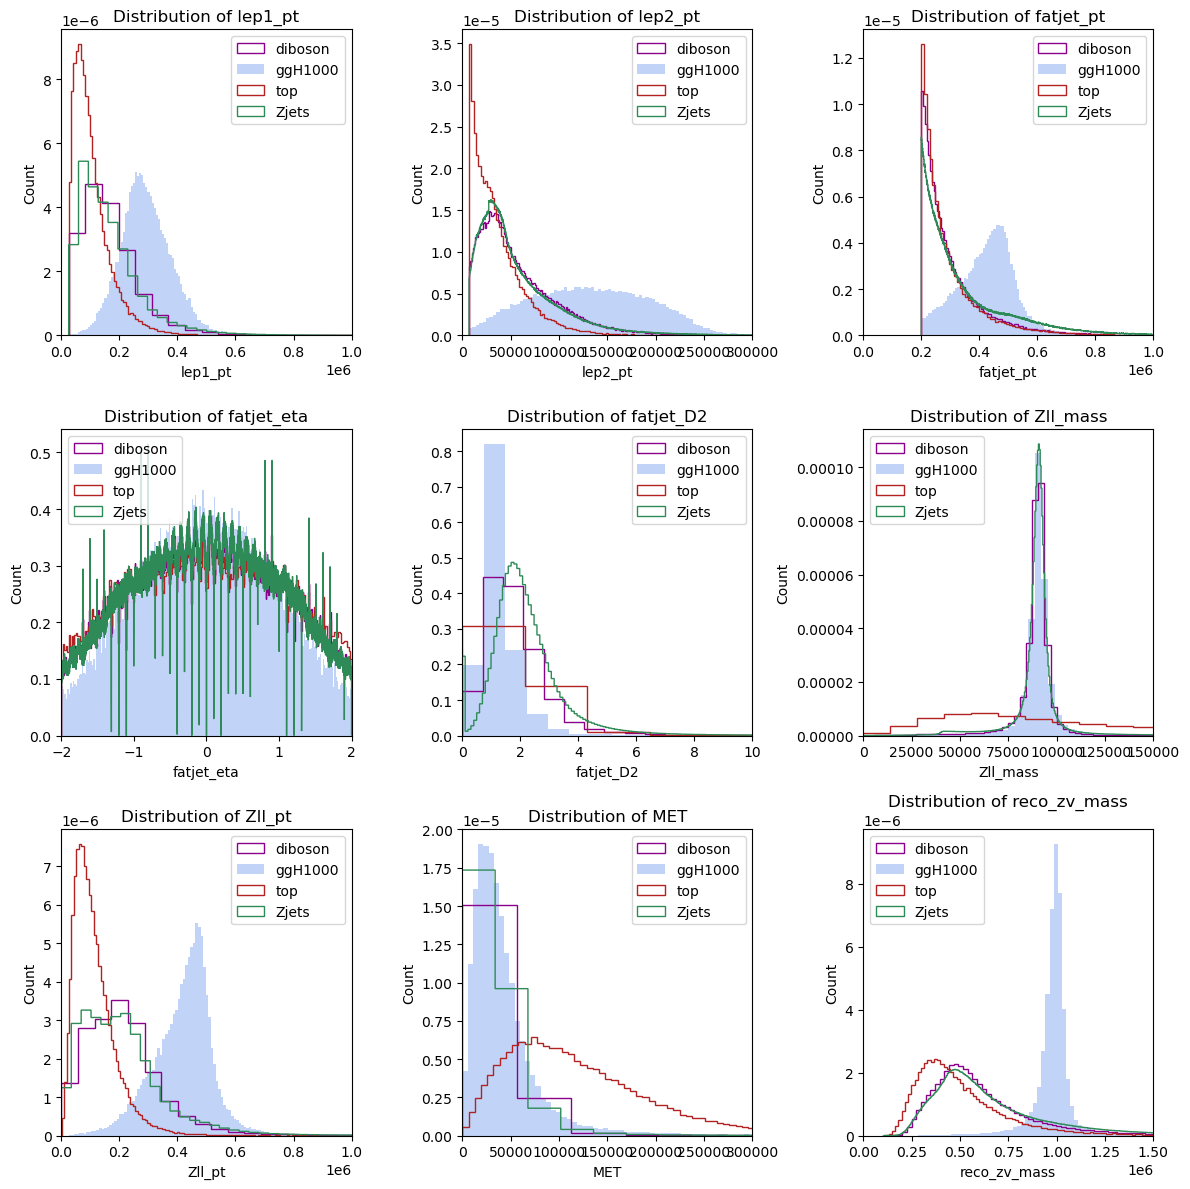

In [15]:
# plotting the kinematic distributions for each process and overlaying them

lower = np.array([0,0,0,-2,0,0,0,0,0])      # setting the lower x-range for the loop
upper = np.array([1e6, 0.3e6, 1e6, 2, 10,1.5e5, 1e6, 3e5, 1.5e6])     # setting the upper x-range for the loop

fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.2, wspace =0.2)

for i in range(1,10): # as there are 9 kinematic variables we want to look at
    axes = fig.add_subplot(3,3,i)
    axes.hist(diboson2[names[i-1]], bins = 500,  label='diboson', density=True, histtype='step', color='darkmagenta')
    axes.hist(gg2[names[i-1]], bins = 200,  label='ggH1000', density=True, color='cornflowerblue', alpha=0.4)
    axes.hist(top2[names[i-1]], bins = 200, density=True, label='top', histtype='step', color='firebrick')
    axes.hist(zjets2[names[i-1]], bins = 10000,  label='Zjets', density=True, histtype='step', color='seagreen')
    axes.legend()
    axes.set_title("Distribution of " + str(names[i-1]))
    axes.set_xlabel(str(names[i-1]))
    axes.set_ylabel("Count")

    axes.set_xlim((lower[i-1], upper[i-1]))

fig.tight_layout()

### Roughly the cuts I want to apply:

lep1_pt: > 150 000

lep2_pt: > 30000

fatjet_pt: > 0.3e6

fatjet_eta: no cut?

fatjet_D2: 0.1 < > 3

Zll_mass: 72 000 < > 115000

Zll_pt: 270000 < > 700 000

MET: < 100000

In [17]:
# lep1_pt cuts

diboson_cut = diboson2[diboson2.lep1_pt > 150000]
gg_cut = gg2[gg2.lep1_pt > 150000]
top_cut = top2[top2.lep1_pt > 150000]
zjets_cut = zjets2[zjets2.lep1_pt > 150000]


In [18]:
# lep2_pt cuts

diboson_cut = diboson_cut[diboson_cut.lep2_pt > 30000]
gg_cut = gg_cut[gg_cut.lep2_pt > 30000]
top_cut = top_cut[top_cut.lep2_pt > 30000]
zjets_cut = zjets_cut[zjets_cut.lep2_pt > 30000]

In [19]:
# fatjet_pt cuts

diboson_cut = diboson_cut[diboson_cut.fatjet_pt > 0.3e6]
gg_cut = gg_cut[gg_cut.fatjet_pt > 0.3e6]
top_cut = top_cut[top_cut.fatjet_pt > 0.3e6]
zjets_cut = zjets_cut[zjets_cut.fatjet_pt > 0.3e6]

In [20]:
# Upper and Lower fatjet_D2 cuts

diboson_cut = diboson_cut[diboson_cut.fatjet_D2 < 3]
gg_cut = gg_cut[gg_cut.fatjet_D2 < 3]
top_cut = top_cut[top_cut.fatjet_D2 < 3]
zjets_cut = zjets_cut[zjets_cut.fatjet_D2 < 3]

diboson_cut = diboson_cut[diboson_cut.fatjet_D2 > 0.1]
gg_cut = gg_cut[gg_cut.fatjet_D2 > 0.1]
top_cut = top_cut[top_cut.fatjet_D2 > 0.1]
zjets_cut = zjets_cut[zjets_cut.fatjet_D2 > 0.1]

In [21]:
# Upper and Lower Zll_mass cuts

diboson_cut = diboson_cut[diboson_cut.Zll_mass > 72000]
gg_cut = gg_cut[gg_cut.Zll_mass > 72000]
top_cut = top_cut[top_cut.Zll_mass > 72000]
zjets_cut = zjets_cut[zjets_cut.Zll_mass > 72000]

diboson_cut = diboson_cut[diboson_cut.Zll_mass < 115000]
gg_cut = gg_cut[gg_cut.Zll_mass < 115000]
top_cut = top_cut[top_cut.Zll_mass < 115000]
zjets_cut = zjets_cut[zjets_cut.Zll_mass < 115000]

In [22]:
# Upper and Lower Zll_pt cuts

diboson_cut = diboson_cut[diboson_cut.Zll_pt > 270000]
gg_cut = gg_cut[gg_cut.Zll_pt > 270000]
top_cut = top_cut[top_cut.Zll_pt > 270000]
zjets_cut = zjets_cut[zjets_cut.Zll_pt > 270000]

diboson_cut = diboson_cut[diboson_cut.Zll_pt < 700000]
gg_cut = gg_cut[gg_cut.Zll_pt < 700000]
top_cut = top_cut[top_cut.Zll_pt < 700000]
zjets_cut = zjets_cut[zjets_cut.Zll_pt < 700000]

In [23]:
# MET cuts

diboson_cut = diboson_cut[diboson_cut.MET < 100000]
gg_cut = gg_cut[gg_cut.MET < 100000]
top_cut = top_cut[top_cut.MET < 100000]
zjets_cut = zjets_cut[zjets_cut.MET < 100000]

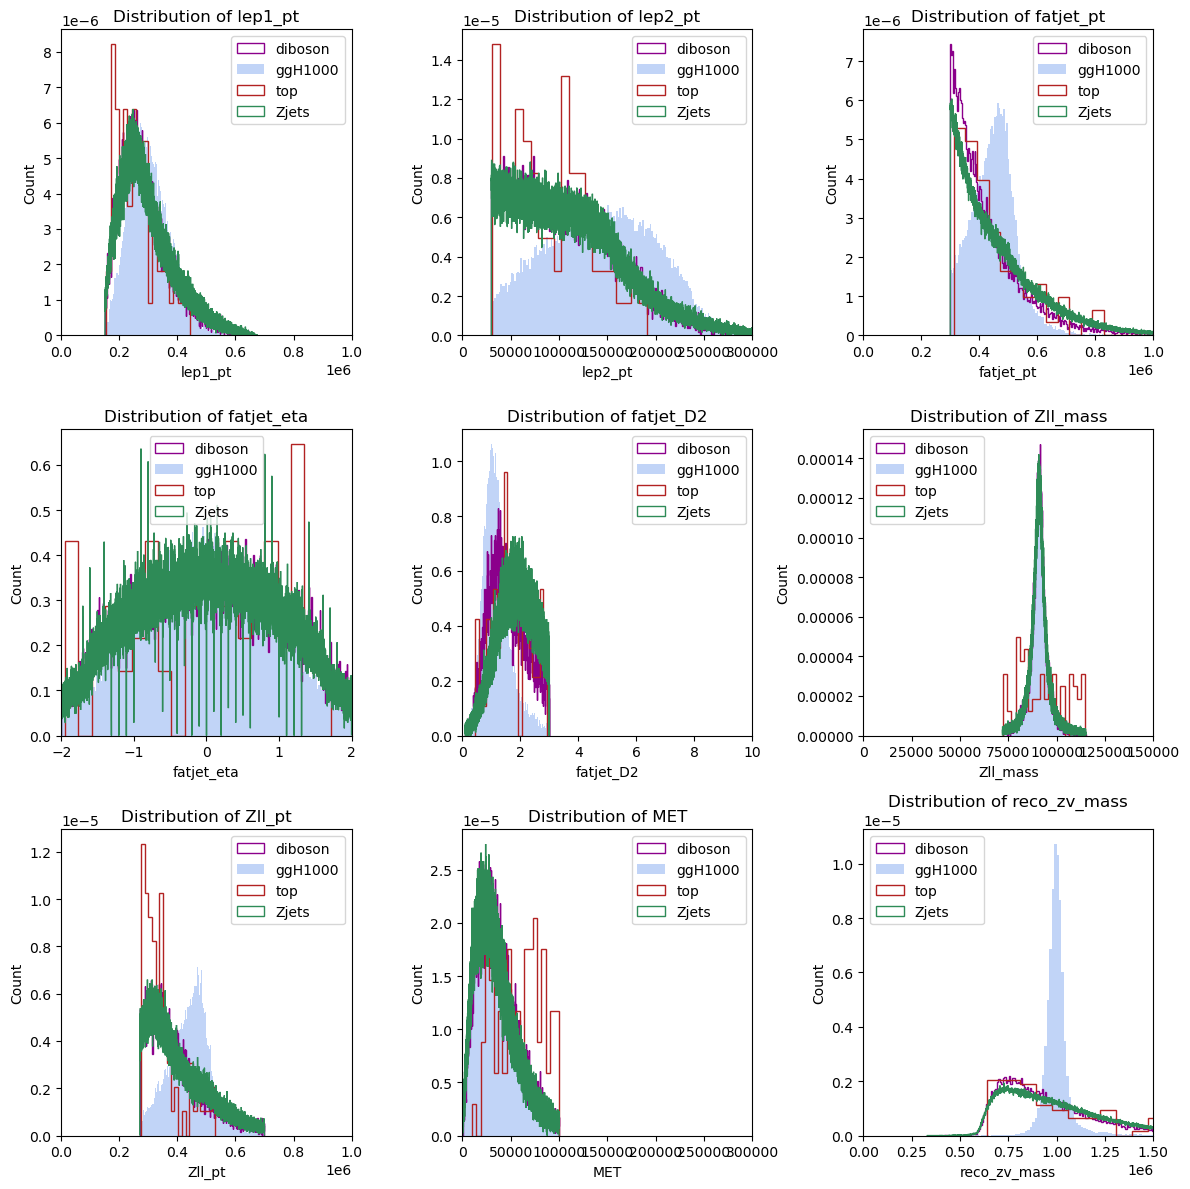

In [24]:
# plotting the kinematic distributions after the cuts have been applied

lower = np.array([0,0,0,-2,0,0,0,0,0])
upper = np.array([1e6, 0.3e6, 1e6, 2, 10,1.5e5, 1e6, 3e5, 1.5e6])

fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.2, wspace =0.2)

for i in range(1,10): # as there are 10 kinematic variables we want to look at
    axes = fig.add_subplot(3,3,i)
    axes.hist(diboson_cut[names[i-1]], bins = 500,  label='diboson', density=True, histtype='step', color='darkmagenta')
    axes.hist(gg_cut[names[i-1]], bins = 200,  label='ggH1000', density=True, color='cornflowerblue', alpha=0.4)
    axes.hist(top_cut[names[i-1]], bins = 20, density=True, label='top', histtype='step', color='firebrick')
    axes.hist(zjets_cut[names[i-1]], bins = 10000,  label='Zjets', density=True, histtype='step', color='seagreen')
    axes.legend()
    axes.set_title("Distribution of " + str(names[i-1]))
    axes.set_xlabel(str(names[i-1]))
    axes.set_ylabel("Count")

    axes.set_xlim((lower[i-1], upper[i-1]))

fig.tight_layout()

### Finding the total number of signal and background events before and after kinematic cuts:

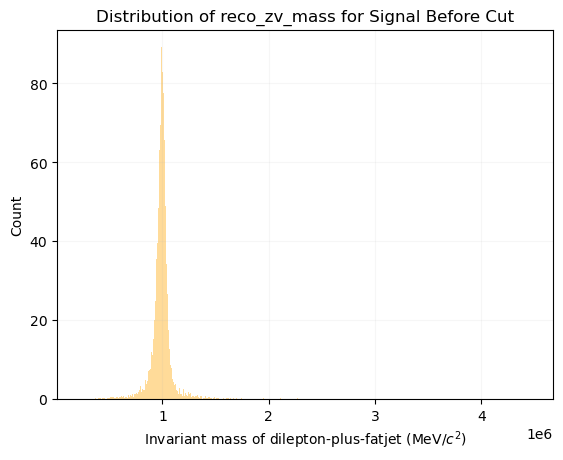

In [27]:
#plt.hist(gg2["reco_zv_mass"], bins = 2000, label='no weights', color = "orange", alpha=0.4)
signal, signal_bins, signal_patches = plt.hist(gg2["reco_zv_mass"], bins = 2000, label='before cut', weights =gg2["FullEventWeight"], color = "orange", alpha=0.4)

plt.xlabel('Invariant mass of dilepton-plus-fatjet (MeV/$c^2$)')
plt.ylabel('Count')
plt.title('Distribution of reco_zv_mass for Signal Before Cut')

plt.grid(alpha=0.1)
plt.show()

Numerical integration

In [28]:
signal_before = sum(signal)*(signal_bins[1] - signal_bins[0])
signal_before

8907511.724466419

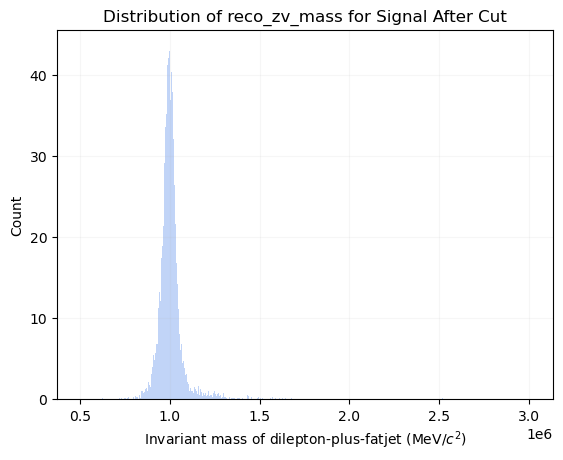

In [29]:
signal2, signal_bins2, signal_patches2 = plt.hist(gg_cut["reco_zv_mass"], bins = 2000, label='after cut', weights =gg_cut["FullEventWeight"], color = "cornflowerblue", alpha=0.4)

plt.xlabel('Invariant mass of dilepton-plus-fatjet (MeV/$c^2$)')
plt.ylabel('Count')
plt.title('Distribution of reco_zv_mass for Signal After Cut')

plt.grid(alpha=0.1)
plt.show()

In [30]:
signal_after = sum(signal2)*(signal_bins2[1] - signal_bins2[0])
signal_after

3785689.3509021825

In [31]:
len(diboson2) + len(top2) + len(zjets2)

6826959

In [32]:
background_combined = pd.concat((diboson2, top2))
background_combined = pd.concat((background_combined, zjets2))

background_combined2 = pd.concat((diboson_cut, top_cut))
background_combined2 = pd.concat((background_combined2, zjets_cut))

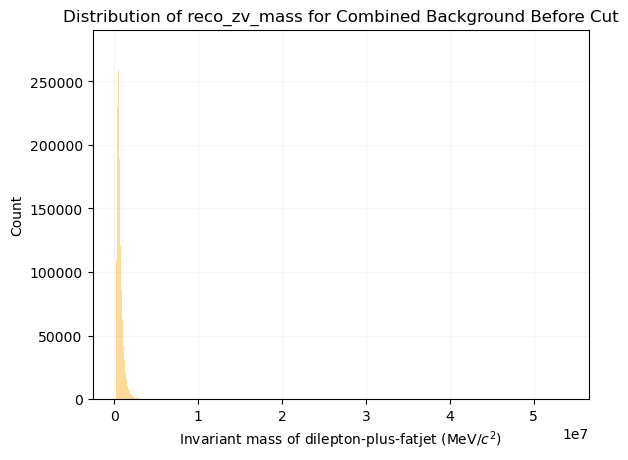

In [33]:
background, background_bins, background_patches = plt.hist(background_combined["reco_zv_mass"], bins = 2000, label='Before cut', weights =background_combined["FullEventWeight"], color = "orange", alpha=0.4)

plt.xlabel('Invariant mass of dilepton-plus-fatjet (MeV/$c^2$)')
plt.ylabel('Count')
plt.title('Distribution of reco_zv_mass for Combined Background Before Cut')

plt.grid(alpha=0.1)
plt.show()

In [34]:
background_before = sum(background)*(background_bins[1] - background_bins[0])
background_before

145133816778.4914

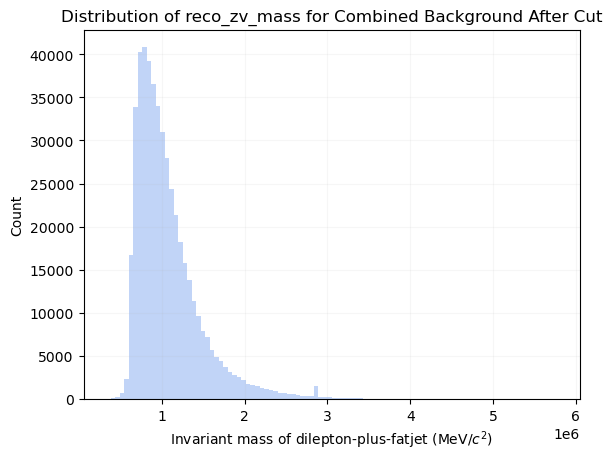

In [35]:
background2, background_bins2, background_patches2 = plt.hist(background_combined2["reco_zv_mass"], bins = 100, label='After cut', weights =background_combined2["FullEventWeight"], color = "cornflowerblue", alpha=0.4)

plt.xlabel('Invariant mass of dilepton-plus-fatjet (MeV/$c^2$)')
plt.ylabel('Count')
plt.title('Distribution of reco_zv_mass for Combined Background After Cut')

plt.grid(alpha=0.1)
plt.show()

In [36]:
background_after = sum(background2)*(background_bins2[1] - background_bins2[0])
background_after

26139158530.428795

In [37]:

(signal_before/ (signal_before + background_before)) * 100

0.006137070781898559

In [38]:
(signal_after/ (signal_after + background_after)) * 100

0.014480730705296527

Here we can see that the percentage of signal events to total number of events doubles when we make the kinematic cuts

This means the signal will be more visible

# Part 2

Because the signal is centred around 1, I'm going to define the range we want to fit over

In [39]:
bg_range = background_combined2[(background_combined2['reco_zv_mass'] > 0.8e6) & (background_combined2['reco_zv_mass'] < 1.4e6)]

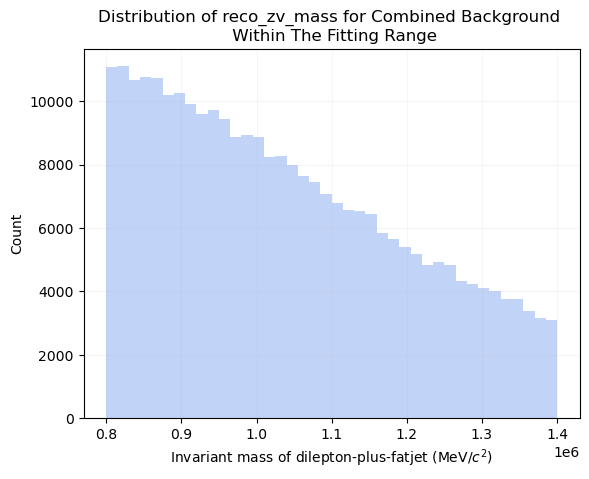

In [40]:
bgd, bgd_bins, bgd_patches = plt.hist(bg_range["reco_zv_mass"], weights = bg_range["FullEventWeight"], color = "cornflowerblue", alpha=0.4, bins=40)

plt.xlabel('Invariant mass of dilepton-plus-fatjet (MeV/$c^2$)')
plt.ylabel('Count')
plt.title('Distribution of reco_zv_mass for Combined Background \n Within The Fitting Range')

plt.grid(alpha=0.1)
plt.show()

$\sigma_i^2$ = $\sum_{j=1}^n$ ($\omega_j^{(i)}$)$^2$

$\chi^2$ = $\sum_i$ = $\frac{[N_{obs}^i - N_{pred}^i]^2}{\sigma_i^2}$

In [41]:
centres = (bgd_bins[:-1] + bgd_bins[1:])/2        # this calculates the centres of each bin by adding neighbouring bin edges and dividing by 2

In [42]:
# simple linear fit function
def linear(m, x, c):

    y = (m * x) + c

    return y

In [43]:
def chisquared(m, c):

    sigma = np.sum((bg_range['FullEventWeight'].values)**2)

    x = centres     # the x values at the centre of each bin (reco_zv_mass)
    y = bgd         # the y values for each bins (counts)

    chisq = np.sum(((y - linear(m, x, c))**2)/ sigma)

    return chisq

In [44]:
m = im(chisquared, m = -1, c = 12500)

m.migrad()
m.hesse()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.178                      │              Nfcn = 52               │
│ EDM = 5.62e-18 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │ -14.7e-3  │  0.8e-3   │            │            │         │         │       │
│ 1 │ c    │  23.2e3   │   0.8e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────────────┐
│   │            m            c │
├───┼───────────────────────────┤
│ m │     5.82e-07 -640.0994e-3 │
│ c │ -640.0994e-3     7.22e+05 │
└───┴───────────────────────────┘

In [45]:
print('Min chisq: ', m.fval)

Min chisq:  2.177596365596144


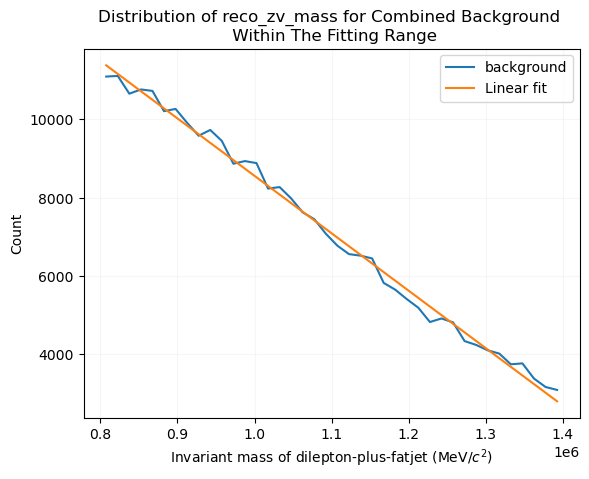

In [46]:
# Plotting how the opimised fit compares to the data

plt.plot(centres, bgd, label='background')
plt.plot(centres, linear(m.values[0], centres, m.values[1]), label='Linear fit')

plt.xlabel('Invariant mass of dilepton-plus-fatjet (MeV/$c^2$)')
plt.ylabel('Count')
plt.title('Distribution of reco_zv_mass for Combined Background \n Within The Fitting Range')

plt.grid(alpha=0.1)
plt.legend()
plt.show()

meh fit...

Next try a 2nd order polynomial:

In [47]:
# Simple second order polynomial function
def poly(a, b, c, x):

    y = (a*x**2) + (b*x) + c

    return y

In [48]:
def poly_chisquared(a, b, c):

    sigma = np.sum((bg_range['FullEventWeight'].values)**2)

    x = centres     # the x values at the centre of each bin (reco_zv_mass)
    y = bgd         # the y values for each bins (counts)

    chisq = np.sum(((y - poly(a, b, c, x))**2)/ sigma)

    return chisq

In [49]:
m2 = im(poly_chisquared, a = 10, b = -1, c = 12500)

m2.migrad()
m2.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.099                      │              Nfcn = 146              │
│ EDM = 7.53e-20 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1e-9    │   5e-9    │            │            │         │         │       │
│ 1 │ b    │  -0.018   │   0.011   │            │            │         │         │       │
│ 2 │ c    │   25e3    │    6e3    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────────────────────────────────────────────────────┐
│   │                  a                  b                  c │
├───┼──────────────────────────────────────────────────────────┤
│ a │           2.43e-17     -53.475732e-12 28.682859029941e-6 │
│ b │     -53.475732e-12           0.000118          -63.74230 │
│ c │ 28.682859029941e-6          -63.74230           3.46e+07 │
└───┴──────────────────────────────────────────────────────────┘

In [50]:
print('Min chisq: ', m2.fval)

Min chisq:  2.098588419319344


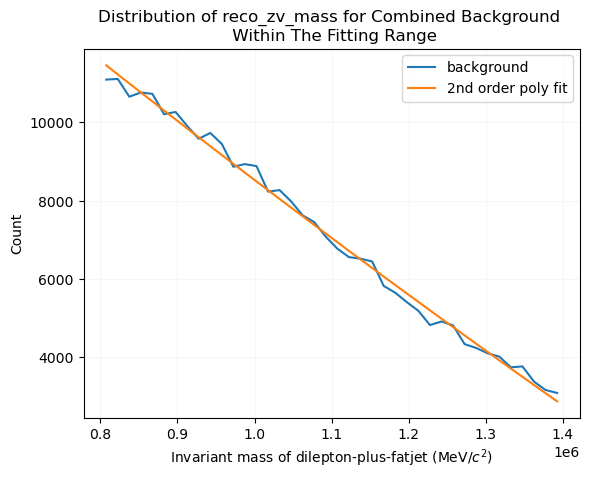

In [51]:
# Plotting how the opimised fit compares to the data

plt.plot(centres, bgd, label='background')
plt.plot(centres, poly(m2.values[0], m2.values[1], m2.values[2], centres), label='2nd order poly fit')

plt.xlabel('Invariant mass of dilepton-plus-fatjet (MeV/$c^2$)')
plt.ylabel('Count')
plt.title('Distribution of reco_zv_mass for Combined Background \n Within The Fitting Range')

plt.grid(alpha=0.1)
plt.legend()
plt.show()

bit better with a slightly better chisq :))

### Now modelling the signal

In [52]:
signal_range = gg_cut[(gg_cut['reco_zv_mass'] > 0.8e6) & (gg_cut['reco_zv_mass'] < 1.4e6)]  # again defining the sub-range to look at

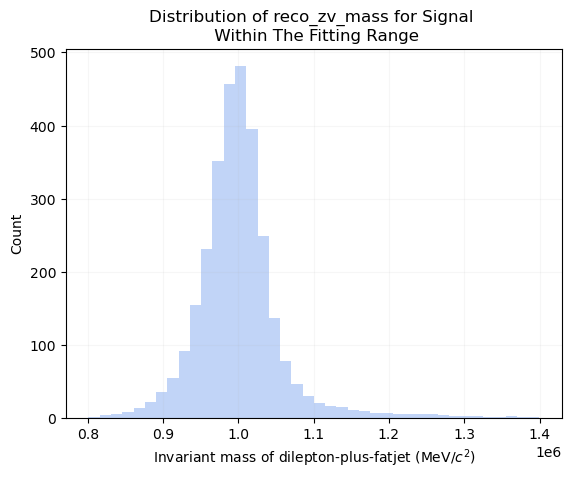

In [53]:
sig, sig_bins, sig_patches = plt.hist(signal_range["reco_zv_mass"], weights = signal_range["FullEventWeight"], color = "cornflowerblue", alpha=0.4, bins=40)

plt.xlabel('Invariant mass of dilepton-plus-fatjet (MeV/$c^2$)')
plt.ylabel('Count')
plt.title('Distribution of reco_zv_mass for Signal \n Within The Fitting Range')

plt.grid(alpha=0.1)
plt.show()

In [54]:
sig_centres = (sig_bins[:-1] + sig_bins[1:])/2        # this calculates the centres of each bin by adding neighbouring bin edges and dividing by 2

In [55]:
# function to fit a gaussian

def gaus(a, mu, sigma):
    
    x = sig_centres
    y = a * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    
    return y

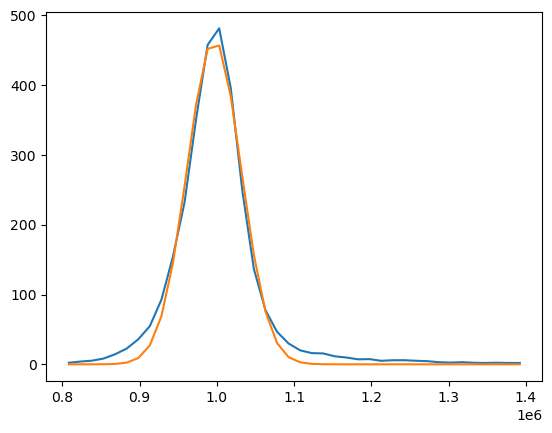

In [56]:
# plot the gaussian with the signal to try and find the right starting parameters

plt.plot(sig_centres, sig)

plt.plot(sig_centres, gaus(a=465, mu=996442, sigma=34909))

In [57]:
# function to calculate the chisquared for a gaussian fit

def chi_gaussian(a,mu,sigma):
    
    z = np.sum((signal_range["FullEventWeight"].values)**2)
    x = sig_centres
    y = sig
    
    
    return np.sum((y - gaus(a, mu, sigma))**2 / z )

In [58]:
m_sig = im(chi_gaussian, a=450, mu=1e6, sigma=35000)

m_sig.migrad()  # run optimiser
m_sig.hesse() 



┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 21.44                      │              Nfcn = 69               │
│ EDM = 9.29e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a     │    466    │    12     │            │            │         │         │       │
│ 1 │ mu    │  996.4e3  │   1.0e3   │            │            │         │         │       │
│ 2 │ sigma │  34.9e3   │   1.1e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────┐
│       │        a       mu    sigma │
├───────┼────────────────────────────┤
│     a │      133   0.44e3  -7.58e3 │
│    mu │   0.44e3  9.3e+05   -0.1e6 │
│ sigma │  -7.58e3   -0.1e6 1.14e+06 │
└───────┴────────────────────────────┘

In [59]:
m_sig.fval

21.43901834522765

$\chi ^2$ is meh 

Next I'll try a lorentzian distribution since that might help with the broader wings of the signal

In [60]:
# function to fit a lorentzian

def lorentz(a, x0, gamma):

    x = sig_centres
    y = a * (gamma / ((x - x0) ** 2 + gamma ** 2))
    
    return y

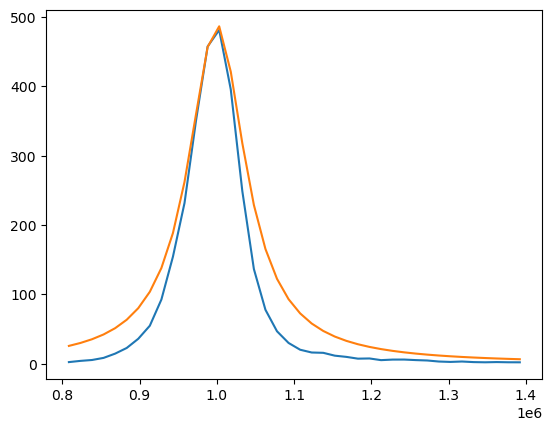

In [61]:
# plot the lorentzian with the signal to try and find the right starting parameters

plt.plot(sig_centres, sig)

plt.plot(sig_centres, lorentz(2.2e7, 1e6, 45000))

In [62]:
# function to calculate the chisquared for a lorentzian fit

def chi_lorentz(a, x0, gamma):
    
    z = np.sum((signal_range["FullEventWeight"].values)**2)
    x = sig_centres
    y = sig
    
    
    return np.sum((y - lorentz(a, x0, gamma))**2 / z )

In [63]:
m_sig2 = im(chi_lorentz, a=2.2e7, x0=1e6, gamma=45000)

m_sig2.migrad()  # run optimiser
m_sig2.hesse() 

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 23.05                      │              Nfcn = 94               │
│ EDM = 0.00011 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a     │  16.7e6   │   0.4e6   │            │            │         │         │       │
│ 1 │ x0    │  997.1e3  │   0.9e3   │            │            │         │         │       │
│ 2 │ gamma │  32.5e3   │   1.2e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────┐
│       │        a       x0    gamma │
├───────┼────────────────────────────┤
│     a │ 1.99e+11  -14.3e6  362.9e6 │
│    x0 │  -14.3e6  8.7e+05   -0.1e6 │
│ gamma │  362.9e6   -0.1e6 1.41e+06 │
└───────┴────────────────────────────┘

In [64]:
m_sig2.fval

23.04598542428748

This $\chi ^2$ is actually slightly worse so maybe a combination of the two would work better?

Okay now I'm going to try a combination of a gaussian and lorentzian

In [65]:
# function to make a gaussian + lorentzian plot

def plot_gaussian_lorentzian(a, b, mu_gaussian, sigma_gaussian, x0_lorentzian, gamma_lorentzian, weight_gaussian=0.5):
    x = sig_centres
    gaussian = a * np.exp(-0.5 * ((x - mu_gaussian) / sigma_gaussian) ** 2)
    lorentzian = b * (gamma_lorentzian / ((x - x0_lorentzian) ** 2 + gamma_lorentzian ** 2))
    combined = weight_gaussian * gaussian + (1 - weight_gaussian) * lorentzian
    plt.plot(x, combined)
    plt.title('Combined Gaussian and Lorentzian Distribution')
    plt.xlabel('x')
    plt.ylabel('Probability Density')
    plt.show()


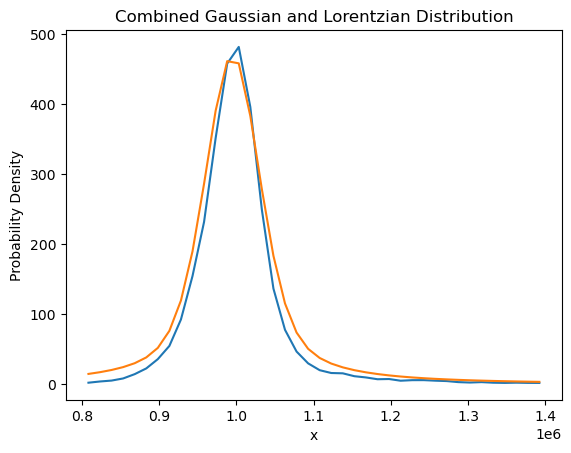

In [66]:
# plotting with the signal distribution so I can get a feel for what parameter to give to minuit
plt.plot(sig_centres, sig)
plot_gaussian_lorentzian(a=500, b=2.2e7, mu_gaussian=0.995e6, sigma_gaussian=35000, x0_lorentzian=0.995e6, gamma_lorentzian=50000, weight_gaussian=0.5)

In [67]:
# function which calculates a gaussian + lorentzian

def gaussian_lorentzian(a, b, mu_gaussian, sigma_gaussian, x0_lorentzian, gamma_lorentzian, weight_gaussian=0.5):
    
    x = sig_centres
    
    gaussian = a * np.exp(-0.5 * ((x - mu_gaussian) / sigma_gaussian) ** 2)
    lorentzian = b * (gamma_lorentzian / ((x - x0_lorentzian) ** 2 + gamma_lorentzian ** 2))
    combined = weight_gaussian * gaussian + (1 - weight_gaussian) * lorentzian
    
    return combined

In [68]:
# function to calculate the chisquared for a gaussian + lorentzian fit

def chi_gaussian_lorentz(a, b, mu_gaussian, sigma_gaussian, x0_lorentzian, gamma_lorentzian, weight_gaussian=0.5):
    
    z = np.sum((signal_range["FullEventWeight"].values)**2)
    x = sig_centres
    y = sig
    
    
    return np.sum((y - gaussian_lorentzian(a, b, mu_gaussian, sigma_gaussian, x0_lorentzian, gamma_lorentzian, weight_gaussian))**2 / z )

In [69]:
m_sig3 = im(chi_gaussian_lorentz, a=500, b=2.2e7, mu_gaussian=0.995e6, sigma_gaussian=35000, x0_lorentzian=0.995e6, gamma_lorentzian=50000, weight_gaussian=0.5)
m_sig3.migrad()  # run optimiser
m_sig3.hesse() 

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.995                      │              Nfcn = 577              │
│ EDM = 4.84e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name             │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a                │  0.53e3   │  0.17e3   │            │            │         │         │       │
│ 1 │ b                │  0.022e9  │  0.014e9  │            │            │         │         │       │
│ 2 │ mu_gaussian      │  1.002e6  │  0.006e6  │            │            │         │         │       │
│ 3 │ sigma_gaussian   │  27.8e3   │   3.5e3   │            │            │         │         │       │
│ 4 │ x0_lorentzian    │  0.979e6  │  0.011e6  │            │            │         │         │       │
│ 5 │ gamma_lorentzian │  0.047e6  │  0.017e6  │            │            │         │         │       │
│ 6 │ weight_gaussian  │   0.66    │   0.24    │            │            │         │         │       │
└───┴──────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                  │                a                b      mu_gaussian   sigma_gaussian    x0_lorentzian gamma_lorentzian  weight_gaussian │
├──────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                a │         3.03e+04      -2.308864e9         -0.079e6          0.030e6         -0.178e6          0.332e6           -33.80 │
│                b │      -2.308864e9         1.86e+14           1.89e9         -2.399e9          -4.45e9          -0.21e9     2.85795208e6 │
│      mu_gaussian │         -0.079e6           1.89e9         3.63e+07         -0.019e9          -0.02e9          -0.10e9          -521.95 │
│   sigma_gaussian │          0.030e6         -2.399e9         -0.019e9         1.22e+07          0.006e9          0.050e9           314.48 │
│    x0_lorentzian │         -0.178e6          -4.45e9          -0.02e9          0.006e9         1.19e+08           0.01e9          -558.85 │
│ gamma_lorentzian │          0.332e6          -0.21e9          -0.10e9          0.050e9           0.01e9         3.08e+08        1.65949e3 │
│  weight_gaussian │           -33.80     2.85795208e6          -521.95           314.48          -558.85        1.65949e3           0.0597 │
└──────────────────┴────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [70]:
m_sig3.fval

3.9954269256818384

yay we got better fit values and a better $\chi^2$!

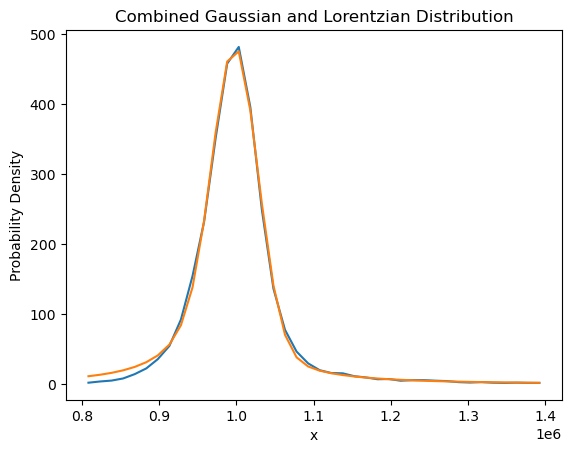

In [71]:
# plot to see how much the better fit is of the minimised chisquared

plt.plot(sig_centres, sig)
plot_gaussian_lorentzian(a=m_sig3.values[0], b=	m_sig3.values[1], mu_gaussian=m_sig3.values[2], sigma_gaussian=m_sig3.values[3], x0_lorentzian=m_sig3.values[4], gamma_lorentzian=m_sig3.values[5], weight_gaussian=m_sig3.values[6])

okay this looks pretty good

#### Combining the signal and background:

In [72]:
bg_range    # reminder of what the dataframe looks like

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,isSignal,FullEventWeight
430,504898.44,36955.650,553120.70,-1.829891,1.198589,102330.020,533877.60,97837.310,1141143.80,0,0.183404
669,207646.70,177396.600,547672.44,-0.203818,0.141573,89665.480,380321.90,14506.293,993538.25,0,0.056997
677,407608.44,75616.020,604850.00,0.895824,2.035448,100195.120,482637.62,28121.680,1341863.00,0,0.052306
702,194626.52,183065.610,496611.25,-0.173499,1.973979,88430.610,370452.78,13678.675,861465.10,0,0.056463
705,445831.22,45808.438,449485.10,0.421468,1.128440,86202.170,484161.53,33911.660,1000438.00,0,0.053254
...,...,...,...,...,...,...,...,...,...,...,...
6570933,311530.50,39998.836,368154.44,-0.133373,1.411549,75028.520,344361.20,45072.863,924957.30,0,0.807472
6571069,300382.72,42919.920,407427.80,0.537276,2.184325,77518.020,341214.72,49517.883,995218.30,0,0.756964
6571307,313692.34,63680.440,420569.66,0.093734,2.771006,77005.586,370014.50,52826.527,1040234.30,0,1.291395
6576477,214880.81,175530.220,410165.20,-0.698303,2.203571,77441.490,385161.56,46319.400,832138.60,0,0.813956


In [73]:
signal_range    # reminder of what the dataframe looks like

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,isSignal,FullEventWeight
0,320104.62,312638.44,480641.84,-0.851387,0.889354,87475.550,627990.80,44495.7700,1063465.80,1,0.013603
1,288589.78,129548.62,375352.78,1.041311,1.485706,90507.310,409780.94,34441.1560,974210.75,1,0.242178
2,228625.23,118590.28,555879.20,0.417858,1.219367,89765.850,344668.30,21625.3790,996837.40,1,0.096412
3,302502.84,233439.89,430646.20,0.438590,0.592705,92313.630,535629.06,21855.9730,989655.56,1,0.096373
5,382829.56,97214.29,488729.16,0.173189,1.179056,96002.460,477601.20,31344.6230,1021392.80,1,0.074408
...,...,...,...,...,...,...,...,...,...,...,...
50007,313474.30,76187.36,401979.12,1.841731,1.249775,90907.670,387827.50,2560.9631,1014964.75,1,0.078524
50008,281285.56,188722.19,485725.50,1.350267,0.492475,91455.810,462688.16,25252.4140,1054015.90,1,0.080738
50009,292794.56,76524.93,442907.28,-1.504514,1.347116,78827.555,360947.12,29533.6230,875460.00,1,0.076554
50011,333331.06,84810.95,450385.88,-0.582446,1.003607,89887.110,417055.56,11857.5870,978088.25,1,0.073220


In [74]:
combined_signal_cut = np.concatenate((bg_range, signal_range))      # combining the signal and background

In [75]:

data_combined_cut = pd.DataFrame(combined_signal_cut, columns = names)      # converting to a dataframe

In [76]:
combined = data_combined_cut
combined

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,isSignal,FullEventWeight
0,504898.44,36955.650,553120.70,-1.829891,1.198589,102330.020,533877.60,97837.3100,1141143.80,0.0,0.183404
1,207646.70,177396.600,547672.44,-0.203818,0.141573,89665.480,380321.90,14506.2930,993538.25,0.0,0.056997
2,407608.44,75616.020,604850.00,0.895824,2.035448,100195.120,482637.62,28121.6800,1341863.00,0.0,0.052306
3,194626.52,183065.610,496611.25,-0.173499,1.973979,88430.610,370452.78,13678.6750,861465.10,0.0,0.056463
4,445831.22,45808.438,449485.10,0.421468,1.128440,86202.170,484161.53,33911.6600,1000438.00,0.0,0.053254
...,...,...,...,...,...,...,...,...,...,...,...
408041,313474.30,76187.360,401979.12,1.841731,1.249775,90907.670,387827.50,2560.9631,1014964.75,1.0,0.078524
408042,281285.56,188722.190,485725.50,1.350267,0.492475,91455.810,462688.16,25252.4140,1054015.90,1.0,0.080738
408043,292794.56,76524.930,442907.28,-1.504514,1.347116,78827.555,360947.12,29533.6230,875460.00,1.0,0.076554
408044,333331.06,84810.950,450385.88,-0.582446,1.003607,89887.110,417055.56,11857.5870,978088.25,1.0,0.073220


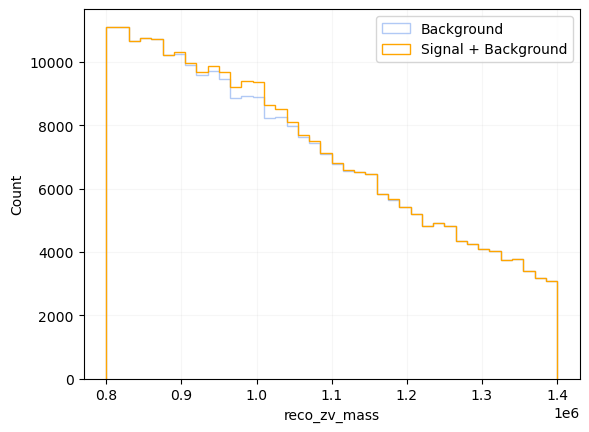

In [189]:
plt.hist(bg_range["reco_zv_mass"], weights = bg_range["FullEventWeight"], color = "cornflowerblue", bins=40, label='Background', histtype='step', alpha=0.5)
cmb, cmb_bins, cmb_patches = plt.hist(combined["reco_zv_mass"], weights = combined["FullEventWeight"], color = "orange", bins=40, label='Signal + Background', histtype='step')

#plt.xlim(0.8e6, 1.4e6
plt.xlabel('reco_zv_mass')
plt.ylabel('Count')
plt.grid(alpha=0.1)
plt.legend()
plt.show()

In [79]:
new_centres = (cmb_bins[:-1] + cmb_bins[1:]) / 2

In [80]:
def combined_func(const1, const2, const3, const4):
    
    x = new_centres
    
    a = m_sig3.values[0]
    b = m_sig3.values[1]
    mu_gaussian = m_sig3.values[2]
    sigma_gaussian = m_sig3.values[3]
    x0_lorentzian = m_sig3.values[4]
    gamma_lorentzian = m_sig3.values[5]
    weight_gaussian = m_sig3.values[6]
    
    gaussian = a * np.exp(-0.5 * ((x - mu_gaussian) / sigma_gaussian) ** 2)
    lorentzian = b * (gamma_lorentzian / ((x - x0_lorentzian) ** 2 + gamma_lorentzian ** 2))
    both = weight_gaussian * gaussian + (1 - weight_gaussian) * lorentzian
    
    poly = (const1*x**2) + (const2*x) + const3
    
    all = both + (const4 * poly)
    
    return all

In [83]:
def combined_chisq(const1, const2, const3, const4):
    
    z = np.sum((combined["FullEventWeight"].values)**2)
    y = cmb
    
    return np.sum((y - combined_func(const1, const2, const3, const4))**2 / z )

In [84]:
m_cmb1 = im(combined_chisq, const1 = 1e-10, const2 = -0.017, const3 = 26000, const4 = 0.99)
m_cmb1.migrad()  # run optimiser
m_cmb1.hesse() 

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.131                      │              Nfcn = 147              │
│ EDM = 1.74e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ const1 │  1.4e-9   │  1.2e-9   │            │            │         │         │       │
│ 1 │ const2 │  -0.0193  │  0.0017   │            │            │         │         │       │
│ 2 │ const3 │  27.3e3   │   2.0e3   │            │            │         │         │       │
│ 3 │ const4 │    0.9    │    0.1    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────────────────────────────────┐
│        │             const1             const2             const3             const4 │
├────────┼─────────────────────────────────────────────────────────────────────────────┤
│ const1 │           1.41e-18     -1.4680811e-12 -876.5219473223e-9     85.6721625e-12 │
│ const2 │     -1.4680811e-12           2.98e-06         -1.2992928           -17.6e-6 │
│ const3 │ -876.5219473223e-9         -1.2992928           4.08e+06           -179.576 │
│ const4 │     85.6721625e-12           -17.6e-6           -179.576             0.0108 │
└────────┴─────────────────────────────────────────────────────────────────────────────┘

In [85]:
m_cmb1.fval

2.131476959521772

Not a terrible $\chi ^2$ ...

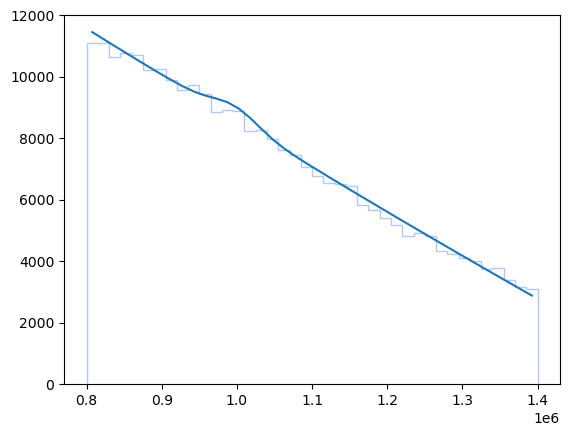

In [86]:
comb_y2 = combined_func(const1 = m_cmb1.values[0], const2 = m_cmb1.values[1], const3 = m_cmb1.values[2], const4 = m_cmb1.values[3])
plt.hist(bg_range["reco_zv_mass"], weights = bg_range["FullEventWeight"], color = "cornflowerblue", bins=40, label='Background', histtype='step', alpha=0.5)
plt.plot(new_centres, comb_y2)
#plt.plot(new_centres, cmb)

plt.show()

We can now see a slight bump

The $H_1$ hypothesis is the signal+background distribution, and the $H_0$ is the background only distribution

In [87]:
# running the minuit fitting a background only distribution

m_H0 = im(poly_chisquared, m2.values[0], m2.values[1], m2.values[2])

m_H0.migrad() 
m_H0.hesse() 

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.099                      │              Nfcn = 54               │
│ EDM = 9.37e-19 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   1e-9    │   5e-9    │            │            │         │         │       │
│ 1 │ b    │  -0.018   │   0.011   │            │            │         │         │       │
│ 2 │ c    │   25e3    │    6e3    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────────────────────────────────────────────────────┐
│   │                  a                  b                  c │
├───┼──────────────────────────────────────────────────────────┤
│ a │           2.41e-17     -53.001718e-12 28.427390839089e-6 │
│ b │     -53.001718e-12           0.000117          -63.17769 │
│ c │ 28.427390839089e-6          -63.17769           3.43e+07 │
└───┴──────────────────────────────────────────────────────────┘

In [88]:
m_H0.fval

2.098588419319338

In [89]:
# running the minuit fitting a signal + background distribution

m_H1 = im(combined_chisq, const1 = m_cmb1.values[0], const2 = m_cmb1.values[1], const3 = m_cmb1.values[2], const4 = m_cmb1.values[3])

m_H1.migrad() 
m_H1.hesse() 

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.131                      │              Nfcn = 73               │
│ EDM = 2.43e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ const1 │  1.4e-9   │  1.2e-9   │            │            │         │         │       │
│ 1 │ const2 │  -0.0193  │  0.0017   │            │            │         │         │       │
│ 2 │ const3 │  27.3e3   │   2.0e3   │            │            │         │         │       │
│ 3 │ const4 │    0.9    │    0.1    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────────────────────────────────┐
│        │             const1             const2             const3             const4 │
├────────┼─────────────────────────────────────────────────────────────────────────────┤
│ const1 │           1.41e-18     -1.4679370e-12 -877.0591005755e-9     85.6994301e-12 │
│ const2 │     -1.4679370e-12           2.98e-06         -1.2989154           -17.7e-6 │
│ const3 │ -877.0591005755e-9         -1.2989154           4.08e+06           -179.633 │
│ const4 │     85.6994301e-12           -17.7e-6           -179.633             0.0108 │
└────────┴─────────────────────────────────────────────────────────────────────────────┘

In [90]:
m_H1.fval

2.1314768091909895

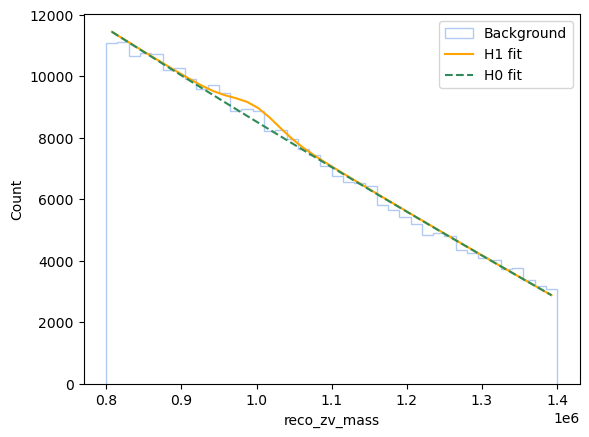

In [91]:
plt.hist(bg_range["reco_zv_mass"], weights = bg_range["FullEventWeight"], color = "cornflowerblue", bins=40, label='Background', histtype='step', alpha=0.5)

plt.plot(new_centres, combined_func(m_H1.values[0], m_H1.values[1], m_H1.values[2], m_H1.values[3]), label = "H1 fit", color = "orange")
plt.plot(new_centres, poly(m_H0.values[0], m_H0.values[1], m_H0.values[2], new_centres), label = "H0 fit", color = "seagreen", linestyle = "dashed")

plt.xlabel("reco_zv_mass")
plt.ylabel("Count")

plt.legend()
plt.show()

In [92]:
delta_chisq = m_H1.fval - m_H0.fval
delta_chisq

0.03288838987165166

In [93]:
# 1 degree of freedom as only one parameter change between the two fits
dof = 1 

p_value_diff = 1-chi2.cdf(delta_chisq,dof) # calculate p-value using chi square cdf
n_sigmas_diff = erfinv(1-p_value_diff)*np.sqrt(2)
print("The P value = "+str(p_value_diff))
print("The Z value = "+str(n_sigmas_diff)+" sigmas")

The P value = 0.8560916345060486
The Z value = 0.18135156429336807 sigmas


------

# Employing a NN classifier

I'm not really sure which dataset to use for training the NN. I feel like after applying the cuts it was a bit harder to distingush what was going on between the background datasets. I'll start off with the uncut versions and see what happens.

In [94]:
# remind ourselves of what the uncut signal data frame looks like
gg2

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,isSignal,FullEventWeight
0,320104.62,312638.44,480641.84,-0.851387,0.889354,87475.550,627990.80,44495.770,1063465.80,1,0.013603
1,288589.78,129548.62,375352.78,1.041311,1.485706,90507.310,409780.94,34441.156,974210.75,1,0.242178
2,228625.23,118590.28,555879.20,0.417858,1.219367,89765.850,344668.30,21625.379,996837.40,1,0.096412
3,302502.84,233439.89,430646.20,0.438590,0.592705,92313.630,535629.06,21855.973,989655.56,1,0.096373
4,224785.02,76205.98,244348.40,1.213717,0.724910,89451.920,296257.47,33677.380,993398.30,1,0.073052
...,...,...,...,...,...,...,...,...,...,...,...
50008,281285.56,188722.19,485725.50,1.350267,0.492475,91455.810,462688.16,25252.414,1054015.90,1,0.080738
50009,292794.56,76524.93,442907.28,-1.504514,1.347116,78827.555,360947.12,29533.623,875460.00,1,0.076554
50010,423855.97,202405.75,227088.28,-0.375119,0.651775,95176.640,621877.06,48633.637,963595.50,1,0.076300
50011,333331.06,84810.95,450385.88,-0.582446,1.003607,89887.110,417055.56,11857.587,978088.25,1,0.073220


In [95]:
# remind ourselves of what the uncut background data frame looks like
background_combined

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,isSignal,FullEventWeight
0,369495.34,9755.2705,345940.12,-0.001591,1.786927,187549.810,374316.600,41920.540,1014320.10,0,0.387345
1,36972.74,14584.7360,218057.10,-1.066937,2.296220,13106.807,51429.535,225618.530,240295.97,0,0.172328
2,146895.95,19119.7030,274339.25,0.704825,3.360730,84519.230,153790.270,42284.125,471285.40,0,0.371392
3,109699.72,8277.4480,444837.44,0.095546,0.702838,76138.640,102611.836,42735.938,495503.10,0,0.309902
4,151453.40,13848.2230,250422.77,-1.828396,3.634348,86138.000,141886.280,70475.780,498823.40,0,0.202772
...,...,...,...,...,...,...,...,...,...,...,...
6579411,152841.81,63417.7070,234758.52,-1.775256,2.056942,67672.120,207361.190,82354.960,594789.10,0,0.900836
6579412,78863.38,40085.7400,262564.80,-0.046267,2.163246,38196.727,114521.740,165134.640,425267.30,0,0.718713
6579413,87776.02,28002.7380,345795.50,1.868530,1.367174,25053.380,114840.290,286209.000,493590.40,0,0.815990
6579414,198423.47,14492.7140,305589.78,1.087642,3.705049,52209.746,209460.080,69904.350,508649.44,0,1.038871


Because we want a 50 50 mixture of background and signal, I will take the max amount of signal we have, and the same amount from the background

In [96]:
bg_shuf = shuffle(background_combined, random_state=42)    # shuffle
bg_reset = bg_shuf.reset_index(drop=True)      # reset index

In [97]:
# take the first 50013 rows from the background dataframe - because we reshuffled and re-indexed, this should be random
big_bg = bg_reset.iloc[:50013]
big_bg

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,isSignal,FullEventWeight
0,68919.25,37852.277,223437.77,1.514261,4.669704,90305.87,90704.12,20284.107,311790.30,0,0.793987
1,306919.80,14977.175,343508.84,0.762631,2.518028,97442.87,311373.88,43325.453,697349.56,0,0.919051
2,82138.49,10334.085,284249.47,-1.414521,1.248408,59014.31,79294.04,19648.066,759495.75,0,0.831505
3,112093.08,28239.787,285707.75,0.903005,0.993795,93353.29,105875.82,19874.436,797780.10,0,0.783659
4,167765.05,58845.586,232638.55,0.945145,2.421706,88500.25,210529.28,17893.979,558379.00,0,0.843561
...,...,...,...,...,...,...,...,...,...,...,...
50008,181405.53,118271.320,286863.34,-0.502620,15.970510,92654.83,285905.72,9825.197,636487.30,0,-1.610180
50009,237793.39,13746.667,238605.88,0.744672,2.264767,89250.36,249846.56,29077.557,503867.75,0,0.743999
50010,383870.62,28368.396,398334.44,0.253068,2.336186,90895.70,402745.10,26981.941,820481.00,0,0.895408
50011,294287.20,138615.700,368904.84,-1.359725,1.696627,91635.71,427432.60,21812.135,805169.80,0,2.365002


In [98]:
both = [gg2, big_bg]
merged = pd.concat(both, ignore_index=True)

merged2 = shuffle(merged, random_state=42)      # reshuffle
merged3 = merged2.reset_index(drop=True)        # reindex

merged3

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,isSignal,FullEventWeight
0,236095.83,223591.670,471153.53,-1.278958,1.428814,85647.080,451638.40,32944.560,954156.40,1,0.065435
1,280150.56,232889.780,450749.06,-0.891372,0.625325,89382.484,506066.84,15525.514,976539.25,1,0.115353
2,64185.49,26884.627,223781.06,0.843659,1.944962,92099.230,81104.54,47756.270,331165.62,0,0.787328
3,303353.16,170069.780,496729.30,-0.595946,0.711557,89189.390,473213.72,57355.280,986375.30,1,0.073636
4,207192.52,30927.420,218131.97,0.207028,2.025986,82227.000,223506.19,12219.205,469012.70,0,-0.791630
...,...,...,...,...,...,...,...,...,...,...,...
100021,390174.34,70919.030,436243.97,-0.072294,0.359615,108599.360,450300.88,38838.617,923796.94,1,0.071651
100022,345203.12,73308.390,401644.97,-0.376977,1.766176,88828.500,418371.30,60206.670,1443899.10,0,2.859896
100023,195169.30,98706.660,454161.90,-0.629567,5.010462,87029.710,281196.22,23588.572,806017.20,0,0.769594
100024,360028.78,182593.400,515074.75,0.442022,2.344393,81439.720,540881.30,19964.430,1091936.50,1,0.072139


In [99]:
# columns that we want i.e. ignoring reco_zv_mass and FullEventWeight
x = merged3[['lep1_pt', 'lep2_pt', 'fatjet_pt', 'fatjet_eta', 'fatjet_D2', 'Zll_mass', 'Zll_pt', 'MET']]   
y = merged3[['isSignal']] # this is our target

In [100]:
sc = preprocessing.StandardScaler()
input_data = sc.fit_transform(x)
# set random seed
Answertoallquestions= 42
# train - test split of dataset
train_data , test_data , train_target , test_target = model_selection.train_test_split(input_data, y, test_size =0.3 , random_state = Answertoallquestions)
print( train_data.shape, train_target.shape, test_data.shape, test_target.shape)

(70018, 8) (70018, 1) (30008, 8) (30008, 1)


In [101]:
num_outputs = 1

# function to make my model
def my_model(num_inputs, num_nodes, extra_depth):

    model = keras.Sequential()
    model.add(Dense(num_nodes, input_dim = num_inputs, kernel_initializer = 'normal', activation = 'relu'))
    model.add(Dropout(0.2))
    for i in range ( extra_depth ):
        # code up the extra layers here
        model.add(Dense(num_nodes, activation = 'relu'))
    #model.add(Dropout(0.2))

    model.add(Dense(num_outputs, activation = 'sigmoid'))
    # Compile model
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics =['accuracy'])
    return model

In [102]:
# building the first model with 8 inputs, 20 nodes and 1 extra layer
model1 = my_model(8,20,1)

In [103]:
batchSize=500
N_epochs=50

history = model1.fit(train_data, train_target, batch_size = batchSize, epochs = N_epochs, verbose = 1 , validation_data =( test_data, test_target ))

Epoch 1/50
141/141 [==============================] - 1s 2ms/step - loss: 0.4980 - accuracy: 0.8315 - val_loss: 0.3372 - val_accuracy: 0.8694
Epoch 2/50
141/141 [==============================] - 0s 1ms/step - loss: 0.3164 - accuracy: 0.8764 - val_loss: 0.2954 - val_accuracy: 0.8814
Epoch 3/50
141/141 [==============================] - 0s 1ms/step - loss: 0.2988 - accuracy: 0.8831 - val_loss: 0.2878 - val_accuracy: 0.8845
Epoch 4/50
141/141 [==============================] - 0s 1ms/step - loss: 0.2952 - accuracy: 0.8842 - val_loss: 0.2845 - val_accuracy: 0.8854
Epoch 5/50
141/141 [==============================] - 0s 1ms/step - loss: 0.2910 - accuracy: 0.8845 - val_loss: 0.2827 - val_accuracy: 0.8856
Epoch 6/50
141/141 [==============================] - 0s 1ms/step - loss: 0.2882 - accuracy: 0.8861 - val_loss: 0.2808 - val_accuracy: 0.8862
Epoch 7/50
141/141 [==============================] - 0s 1ms/step - loss: 0.2856 - accuracy: 0.8852 - val_loss: 0.2793 - val_accuracy: 0.8864
Epoch 

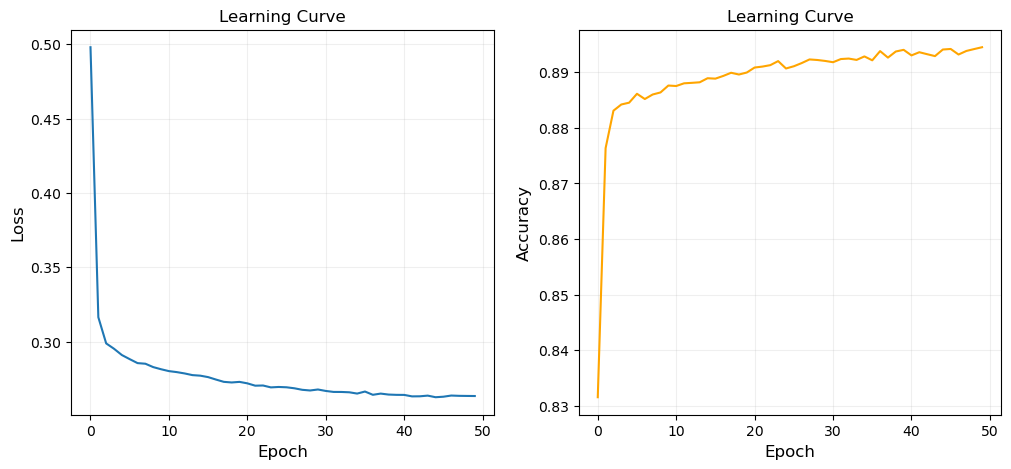

In [104]:

fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].plot(history.history['loss'])
axs[0].set_title('Learning Curve')
axs[0].set_xlabel('Epoch', fontsize=12)
axs[0].set_ylabel('Loss', fontsize=12)
axs[0].grid(alpha=0.2)


axs[1].plot(history.history['accuracy'], color='orange')
axs[1].set_title('Learning Curve')
axs[1].set_xlabel('Epoch', fontsize=12)
axs[1].set_ylabel('Accuracy', fontsize=12)
axs[1].grid(alpha=0.2)

plt.show()

looks okay, doesn't seem to be over training

I'll add in some early callbacks and try a different architecture

In [105]:
# building the second model with 8 inputs, 50 nodes and 5 layers
model2 = my_model(8,50,5)

In [106]:
batchSize=500
N_epochs=100

callbacks_ = [EarlyStopping(verbose = True , patience =10 , monitor = 'val_accuracy'), ModelCheckpoint('model.h5', monitor = 'val_accuracy', save_best_only = True , mode = 'max')]
history2 = model2.fit(train_data, train_target, batch_size = batchSize, epochs = N_epochs, verbose = 1 , validation_data =( test_data, test_target), callbacks=callbacks_)

Epoch 1/100
141/141 [==============================] - 1s 3ms/step - loss: 0.3756 - accuracy: 0.8576 - val_loss: 0.2824 - val_accuracy: 0.8866
Epoch 2/100
141/141 [==============================] - 0s 3ms/step - loss: 0.2809 - accuracy: 0.8879 - val_loss: 0.2778 - val_accuracy: 0.8866
Epoch 3/100
141/141 [==============================] - 0s 3ms/step - loss: 0.2755 - accuracy: 0.8895 - val_loss: 0.2714 - val_accuracy: 0.8906
Epoch 4/100
141/141 [==============================] - 0s 3ms/step - loss: 0.2689 - accuracy: 0.8919 - val_loss: 0.2633 - val_accuracy: 0.8942
Epoch 5/100
141/141 [==============================] - 0s 3ms/step - loss: 0.2643 - accuracy: 0.8932 - val_loss: 0.2626 - val_accuracy: 0.8961
Epoch 6/100
141/141 [==============================] - 0s 3ms/step - loss: 0.2619 - accuracy: 0.8950 - val_loss: 0.2576 - val_accuracy: 0.8958
Epoch 7/100
141/141 [==============================] - 0s 3ms/step - loss: 0.2591 - accuracy: 0.8954 - val_loss: 0.2543 - val_accuracy: 0.8990

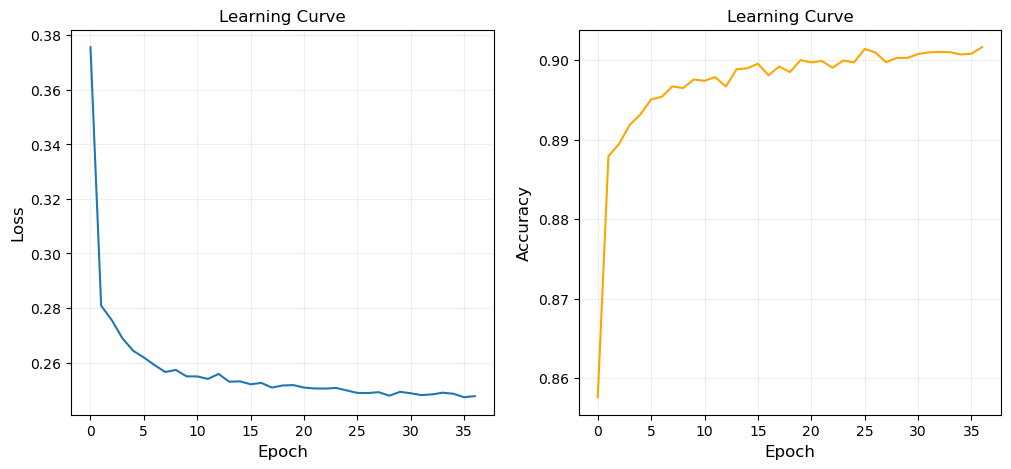

In [107]:

fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].plot(history2.history['loss'])
axs[0].set_title('Learning Curve')
axs[0].set_xlabel('Epoch', fontsize=12)
axs[0].set_ylabel('Loss', fontsize=12)
axs[0].grid(alpha=0.2)


axs[1].plot(history2.history['accuracy'], color='orange')
axs[1].set_title('Learning Curve')
axs[1].set_xlabel('Epoch', fontsize=12)
axs[1].set_ylabel('Accuracy', fontsize=12)
axs[1].grid(alpha=0.2)

plt.show()

this architecture is marginally better but not by much at all hahah

In [108]:
# what does the model predit, given the test data:
predict1 = model2.predict(test_data)

938/938 [==============================] - 0s 396us/step


Now I'll compare what this model predicts the value of is_signal is for the test , vs what the actual test target is: 

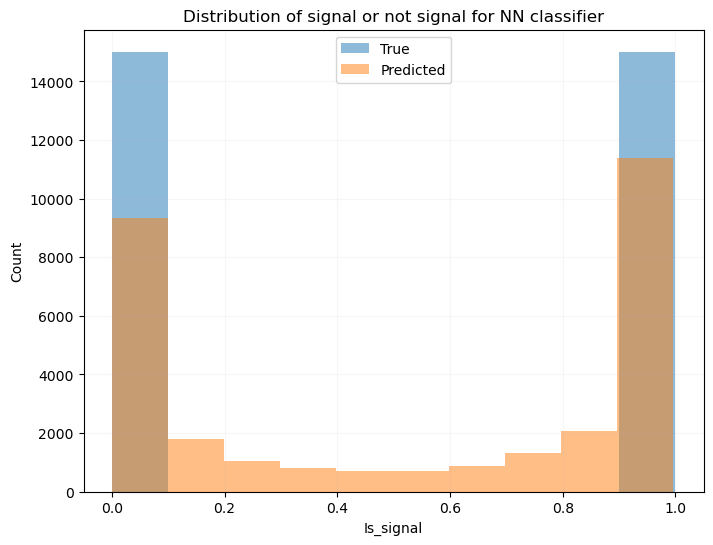

In [111]:
fig,ax = plt.subplots(figsize=(8, 6))

plt.hist(test_target.values, alpha=0.5, label='True')
plt.hist(predict1, alpha=0.5, label='Predicted')

plt.xlabel('Is_signal')
plt.ylabel('Count')
plt.title('Distribution of signal or not signal for NN classifier')

plt.legend()
plt.grid(alpha=0.1)
plt.show()

It obviously hasn't predicted everything right, since there is a bunch of stuff in the middle, but it's okay

Next I'll run it on the full dataset, not just the test dataset

In [112]:
mega = np.concatenate((background_combined, gg2))
mega_df = pd.DataFrame(mega, columns = names)

In [113]:
# columns that we want i.e. ignoring reco_zv_mass and FullEventWeight
mega_x = mega_df[['lep1_pt', 'lep2_pt', 'fatjet_pt', 'fatjet_eta', 'fatjet_D2', 'Zll_mass', 'Zll_pt', 'MET']]   
mega_y = mega_df[['isSignal']] # this is our target

In [114]:
sc = preprocessing.StandardScaler()
mega_input_data = sc.fit_transform(mega_x)

In [115]:

mega_predict = model2.predict(mega_input_data)

214906/214906 [==============================] - 89s 416us/step


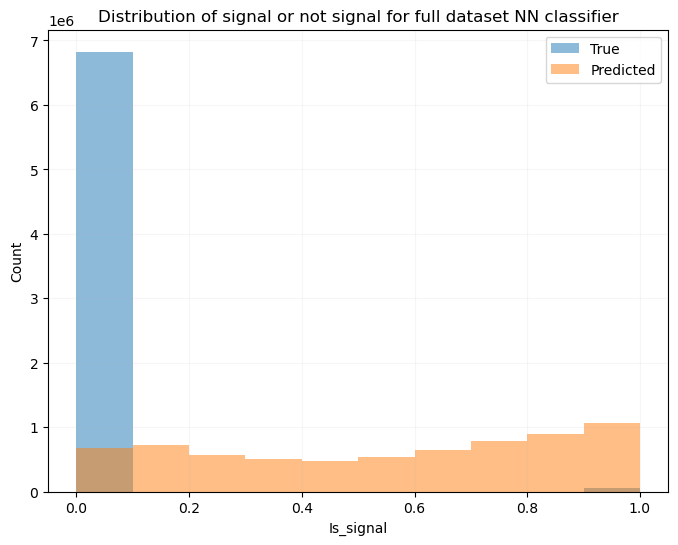

In [117]:
fig,ax = plt.subplots(figsize=(8, 6))

plt.hist(mega_y, alpha=0.5, label='True')
plt.hist(mega_predict, alpha=0.5, label='Predicted')

plt.xlabel('Is_signal')
plt.ylabel('Count')
plt.title('Distribution of signal or not signal for full dataset NN classifier')

plt.legend()
plt.grid(alpha=0.1)
plt.show()

Okay so this doesn't classify well at all hahaha

Maybe I'll try using the cut data instead now?

-------

In [118]:
# remind ourselves of what the cut signal data frame looks like
gg_cut

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,isSignal,FullEventWeight
0,320104.62,312638.44,480641.84,-0.851387,0.889354,87475.550,627990.80,44495.7700,1063465.80,1,0.013603
1,288589.78,129548.62,375352.78,1.041311,1.485706,90507.310,409780.94,34441.1560,974210.75,1,0.242178
2,228625.23,118590.28,555879.20,0.417858,1.219367,89765.850,344668.30,21625.3790,996837.40,1,0.096412
3,302502.84,233439.89,430646.20,0.438590,0.592705,92313.630,535629.06,21855.9730,989655.56,1,0.096373
5,382829.56,97214.29,488729.16,0.173189,1.179056,96002.460,477601.20,31344.6230,1021392.80,1,0.074408
...,...,...,...,...,...,...,...,...,...,...,...
50007,313474.30,76187.36,401979.12,1.841731,1.249775,90907.670,387827.50,2560.9631,1014964.75,1,0.078524
50008,281285.56,188722.19,485725.50,1.350267,0.492475,91455.810,462688.16,25252.4140,1054015.90,1,0.080738
50009,292794.56,76524.93,442907.28,-1.504514,1.347116,78827.555,360947.12,29533.6230,875460.00,1,0.076554
50011,333331.06,84810.95,450385.88,-0.582446,1.003607,89887.110,417055.56,11857.5870,978088.25,1,0.073220


In [119]:
# remind ourselves of what the cut background data frame looks like
background_combined2

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,isSignal,FullEventWeight
374,251710.95,205420.380,629080.80,-0.084646,0.401113,75042.300,452674.66,59256.490,1420048.60,0,0.842353
430,504898.44,36955.650,553120.70,-1.829891,1.198589,102330.020,533877.60,97837.310,1141143.80,0,0.183404
669,207646.70,177396.600,547672.44,-0.203818,0.141573,89665.480,380321.90,14506.293,993538.25,0,0.056997
677,407608.44,75616.020,604850.00,0.895824,2.035448,100195.120,482637.62,28121.680,1341863.00,0,0.052306
699,325282.28,246680.980,621122.80,0.534040,2.914305,92195.660,566365.80,22942.531,1713201.00,0,0.054375
...,...,...,...,...,...,...,...,...,...,...,...
6577808,209191.53,150726.220,346635.56,0.532509,1.627861,82417.830,354166.25,33200.860,939524.75,0,-0.828480
6578039,227405.55,60161.940,317689.06,0.887079,1.249724,84495.700,277517.03,45203.676,649109.80,0,0.894654
6578325,257181.66,93668.710,360600.00,-0.647223,2.402388,81644.260,342781.20,47073.656,792457.70,0,0.805347
6578677,237773.10,77144.060,359867.47,1.364999,2.652656,76647.086,313120.75,51148.400,720927.94,0,0.977556


Because we want a 50 50 mixture of background and signal, I will take the max amount of signal we have, and the same amount from the background

In [120]:
bg_shuf_cut = shuffle(background_combined2, random_state=42)    # shuffle
bg_reset_cut = bg_shuf_cut.reset_index(drop=True)      # reset index

In [121]:
# take the first 36002 rows from the background dataframe - because we reshuffled and re-indexed, this should be random
big_bg_cut = bg_reset_cut.iloc[:36002]
big_bg_cut

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,isSignal,FullEventWeight
0,498859.10,142767.840,499305.20,0.430347,0.992509,90557.586,639156.00,16508.8480,1485960.20,0,0.790172
1,384222.20,33962.820,428145.88,-0.392636,2.176272,88074.580,408810.12,11144.6990,848615.70,0,-0.838782
2,345506.75,197259.340,585252.70,-0.158912,1.498807,88919.000,535435.20,52798.4260,1372068.60,0,1.066103
3,254782.39,60988.113,365963.44,0.253466,2.064692,102428.660,306059.72,15592.8420,704988.25,0,0.797287
4,295753.94,67311.695,427905.03,1.069224,2.210567,91119.020,362320.28,6470.3276,1678493.50,0,0.746212
...,...,...,...,...,...,...,...,...,...,...,...
35997,451088.03,66956.650,443056.70,-1.666782,1.233031,83665.150,512050.00,6969.3936,1066208.10,0,0.713804
35998,219861.17,107176.670,364472.44,1.530144,1.137702,101016.300,326323.90,17321.8340,726121.60,0,0.806577
35999,201488.23,178572.220,377922.34,-0.614648,0.243269,84963.875,379985.60,20696.7250,811063.30,0,1.082272
36000,446896.40,37770.895,485358.10,-0.472336,1.310464,90465.150,477657.56,15487.0480,994375.60,0,-1.048722


In [122]:
both_cut = [gg_cut, big_bg_cut]
merged_cut = pd.concat(both_cut, ignore_index=True)

merged2_cut = shuffle(merged_cut, random_state=42)      # reshuffle
merged3_cut = merged2_cut.reset_index(drop=True)        # reindex

merged3_cut

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,isSignal,FullEventWeight
0,372770.47,118013.730,507134.84,1.246070,1.038727,91380.780,482862.30,28863.271,1025963.2,1,0.074249
1,256239.66,110478.040,570324.06,0.269248,1.043561,88277.640,357820.20,32357.332,906890.1,0,1.083420
2,303196.12,143271.950,495857.06,-1.498538,2.513589,92417.710,438025.16,8199.062,964792.4,0,0.915007
3,263764.84,204816.310,506864.53,0.704625,2.091254,91019.660,462091.00,13206.868,1205348.9,0,0.740887
4,275369.80,184551.120,806644.00,1.119367,2.179493,91552.414,458406.44,20552.086,1692073.8,0,0.800083
...,...,...,...,...,...,...,...,...,...,...,...
71999,313065.30,74733.920,776855.56,0.896999,1.173985,78363.680,387146.38,92166.280,1682041.9,0,0.826082
72000,229685.88,197994.380,452312.38,-1.627003,1.272472,90056.960,421909.40,19103.307,985001.5,1,0.158405
72001,157414.84,139286.620,361225.62,0.396847,2.555481,90606.050,293412.62,36438.150,801067.0,0,0.812672
72002,208710.36,204702.420,359970.53,-0.531883,0.722025,91042.980,410749.75,23155.084,963004.6,1,0.090629


In [123]:
# columns that we want i.e. ignoring reco_zv_mass and FullEventWeight
x_cut = merged3_cut[['lep1_pt', 'lep2_pt', 'fatjet_pt', 'fatjet_eta', 'fatjet_D2', 'Zll_mass', 'Zll_pt', 'MET']]   
y_cut = merged3_cut[['isSignal']] # this is our target

In [124]:
sc = preprocessing.StandardScaler()
input_data_cut = sc.fit_transform(x_cut)
# set random seed
Answertoallquestions= 42
# train - test split of dataset
train_data_cut , test_data_cut , train_target_cut , test_target_cut = model_selection.train_test_split(input_data_cut, y_cut, test_size =0.3 , random_state = Answertoallquestions)
print( train_data_cut.shape, train_target_cut.shape, test_data_cut.shape, test_target_cut.shape)

(50402, 8) (50402, 1) (21602, 8) (21602, 1)


In [125]:
# This is the same model as before, I'm just putting a copy down here to remind ourselves of the architechure

num_outputs = 1

# function to make my model
def my_model(num_inputs, num_nodes, extra_depth):

    model = keras.Sequential()
    model.add(Dense(num_nodes, input_dim = num_inputs, kernel_initializer = 'normal', activation = 'relu'))
    model.add(Dropout(0.2))
    for i in range ( extra_depth ):
        # code up the extra layers here
        model.add(Dense(num_nodes, activation = 'relu'))
    model.add(Dropout(0.2))

    model.add(Dense(num_outputs, activation = 'sigmoid'))
    # Compile model
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics =['accuracy'])
    return model

In [126]:
# building the first model for the cut data with 8 inputs, 20 nodes and 1 extra layer - I know I could just use the one from before but I'm trying to make names explicitly different so I don't confuse myself
model_cut_1 = my_model(8,20,1)

In [127]:
batchSize=500
N_epochs=20

history_cut1 = model_cut_1.fit(train_data_cut, train_target_cut, batch_size = batchSize, epochs = N_epochs, verbose = 1 , validation_data =( test_data_cut, test_target_cut ))

Epoch 1/20
101/101 [==============================] - 1s 2ms/step - loss: 0.6137 - accuracy: 0.7032 - val_loss: 0.4945 - val_accuracy: 0.7794
Epoch 2/20
101/101 [==============================] - 0s 1ms/step - loss: 0.4868 - accuracy: 0.7816 - val_loss: 0.4575 - val_accuracy: 0.7936
Epoch 3/20
101/101 [==============================] - 0s 1ms/step - loss: 0.4723 - accuracy: 0.7867 - val_loss: 0.4494 - val_accuracy: 0.7969
Epoch 4/20
101/101 [==============================] - 0s 1ms/step - loss: 0.4674 - accuracy: 0.7915 - val_loss: 0.4440 - val_accuracy: 0.8008
Epoch 5/20
101/101 [==============================] - 0s 1ms/step - loss: 0.4614 - accuracy: 0.7935 - val_loss: 0.4412 - val_accuracy: 0.8015
Epoch 6/20
101/101 [==============================] - 0s 1ms/step - loss: 0.4604 - accuracy: 0.7932 - val_loss: 0.4399 - val_accuracy: 0.8015
Epoch 7/20
101/101 [==============================] - 0s 1ms/step - loss: 0.4586 - accuracy: 0.7947 - val_loss: 0.4387 - val_accuracy: 0.8025
Epoch 

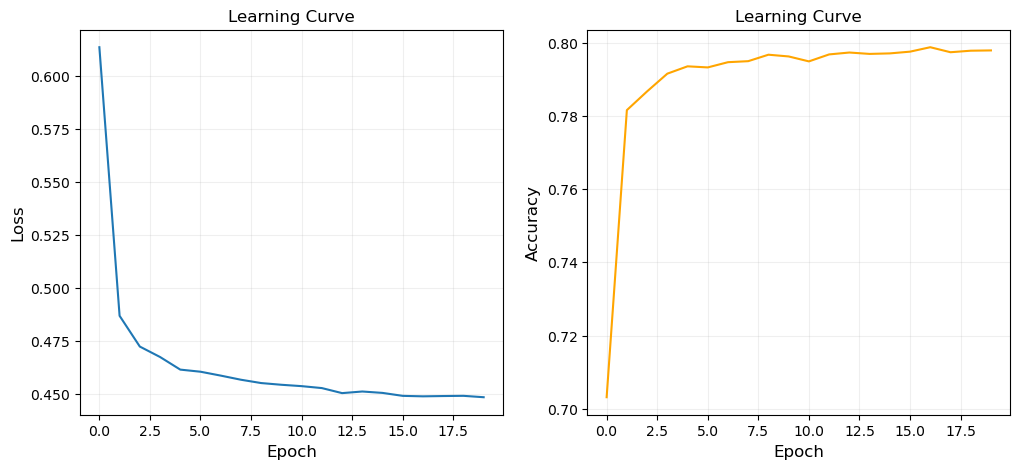

In [128]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].plot(history_cut1.history['loss'])
axs[0].set_title('Learning Curve')
axs[0].set_xlabel('Epoch', fontsize=12)
axs[0].set_ylabel('Loss', fontsize=12)
axs[0].grid(alpha=0.2)


axs[1].plot(history_cut1.history['accuracy'], color='orange')
axs[1].set_title('Learning Curve')
axs[1].set_xlabel('Epoch', fontsize=12)
axs[1].set_ylabel('Accuracy', fontsize=12)
axs[1].grid(alpha=0.2)

plt.show()

Looks okay, could maybe do better though!

In [129]:
# building the second model for the cut data with 8 inputs, 20 nodes and 5 extra layers
model_cut_2 = my_model(8,20,5)

In [130]:
batchSize=500
N_epochs=50

history_cut2 = model_cut_2.fit(train_data_cut, train_target_cut, batch_size = batchSize, epochs = N_epochs, verbose = 1 , validation_data =( test_data_cut, test_target_cut ))

Epoch 1/50
101/101 [==============================] - 1s 3ms/step - loss: 0.5691 - accuracy: 0.7201 - val_loss: 0.4546 - val_accuracy: 0.7963
Epoch 2/50
101/101 [==============================] - 0s 2ms/step - loss: 0.4694 - accuracy: 0.7906 - val_loss: 0.4430 - val_accuracy: 0.8010
Epoch 3/50
101/101 [==============================] - 0s 2ms/step - loss: 0.4584 - accuracy: 0.7956 - val_loss: 0.4374 - val_accuracy: 0.8026
Epoch 4/50
101/101 [==============================] - 0s 3ms/step - loss: 0.4537 - accuracy: 0.7974 - val_loss: 0.4387 - val_accuracy: 0.8012
Epoch 5/50
101/101 [==============================] - 0s 2ms/step - loss: 0.4513 - accuracy: 0.7977 - val_loss: 0.4347 - val_accuracy: 0.8015
Epoch 6/50
101/101 [==============================] - 0s 2ms/step - loss: 0.4490 - accuracy: 0.7974 - val_loss: 0.4366 - val_accuracy: 0.8006
Epoch 7/50
101/101 [==============================] - 0s 2ms/step - loss: 0.4465 - accuracy: 0.7986 - val_loss: 0.4372 - val_accuracy: 0.8016
Epoch 

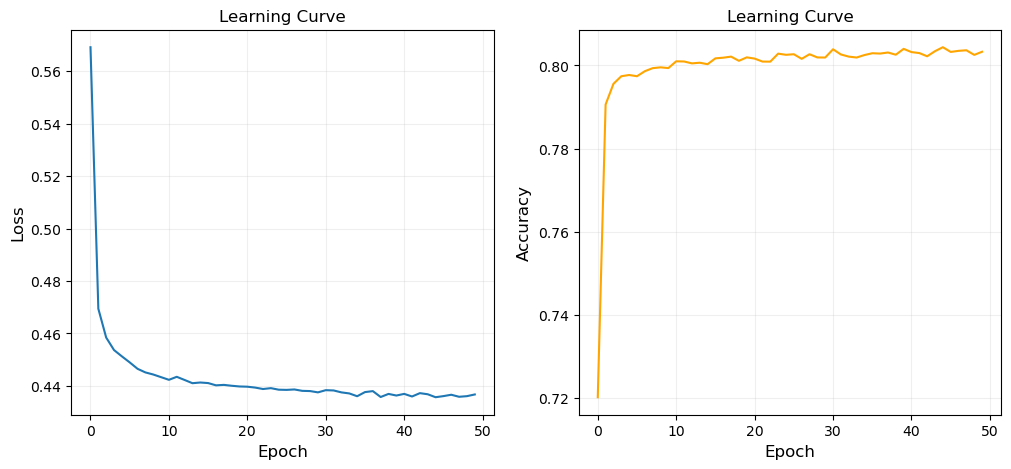

In [131]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].plot(history_cut2.history['loss'])
axs[0].set_title('Learning Curve')
axs[0].set_xlabel('Epoch', fontsize=12)
axs[0].set_ylabel('Loss', fontsize=12)
axs[0].grid(alpha=0.2)


axs[1].plot(history_cut2.history['accuracy'], color='orange')
axs[1].set_title('Learning Curve')
axs[1].set_xlabel('Epoch', fontsize=12)
axs[1].set_ylabel('Accuracy', fontsize=12)
axs[1].grid(alpha=0.2)

plt.show()

Sliiighhttlyyy better but the loss and accuracy isn't as good as the uncut data :/

In [132]:
# building the second model for the cut data with 8 inputs, 20 nodes and 5 extra layers
model_cut_3 = my_model(8,40,5)

In [133]:
batchSize=500
N_epochs=50

callbacks_ = [EarlyStopping(verbose = True , patience =10 , monitor = 'val_accuracy'), ModelCheckpoint('model.h5', monitor = 'val_accuracy', save_best_only = True , mode = 'max')]
history_cut3 = model_cut_3.fit(train_data_cut, train_target_cut, batch_size = batchSize, epochs = N_epochs, verbose = 1 , validation_data =( test_data_cut, test_target_cut ))

Epoch 1/50
101/101 [==============================] - 1s 4ms/step - loss: 0.5231 - accuracy: 0.7678 - val_loss: 0.4495 - val_accuracy: 0.7967
Epoch 2/50
101/101 [==============================] - 0s 3ms/step - loss: 0.4575 - accuracy: 0.7942 - val_loss: 0.4392 - val_accuracy: 0.8012
Epoch 3/50
101/101 [==============================] - 0s 3ms/step - loss: 0.4516 - accuracy: 0.7978 - val_loss: 0.4338 - val_accuracy: 0.8026
Epoch 4/50
101/101 [==============================] - 0s 3ms/step - loss: 0.4464 - accuracy: 0.7996 - val_loss: 0.4344 - val_accuracy: 0.8019
Epoch 5/50
101/101 [==============================] - 0s 3ms/step - loss: 0.4436 - accuracy: 0.8003 - val_loss: 0.4281 - val_accuracy: 0.8050
Epoch 6/50
101/101 [==============================] - 0s 3ms/step - loss: 0.4414 - accuracy: 0.8002 - val_loss: 0.4300 - val_accuracy: 0.8038
Epoch 7/50
101/101 [==============================] - 0s 2ms/step - loss: 0.4410 - accuracy: 0.8006 - val_loss: 0.4271 - val_accuracy: 0.8057
Epoch 

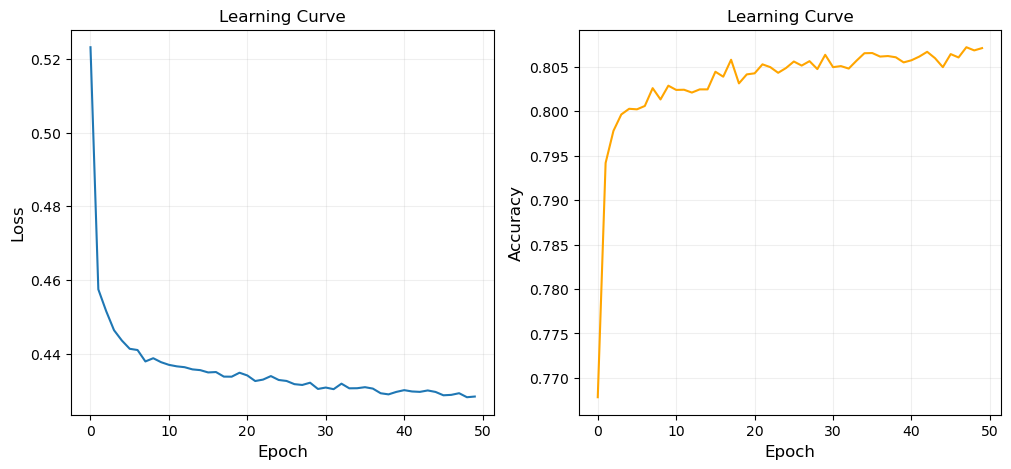

In [134]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].plot(history_cut3.history['loss'])
axs[0].set_title('Learning Curve')
axs[0].set_xlabel('Epoch', fontsize=12)
axs[0].set_ylabel('Loss', fontsize=12)
axs[0].grid(alpha=0.2)


axs[1].plot(history_cut3.history['accuracy'], color='orange')
axs[1].set_title('Learning Curve')
axs[1].set_xlabel('Epoch', fontsize=12)
axs[1].set_ylabel('Accuracy', fontsize=12)
axs[1].grid(alpha=0.2)

plt.show()

I'll see what this model predicts before reverting back to the uncut data for the rest of the analysis but I suspect it won't work well

In [135]:
# what does the model predit, given the test data:
predict_cut_1 = model_cut_3.predict(test_data_cut)

676/676 [==============================] - 0s 407us/step


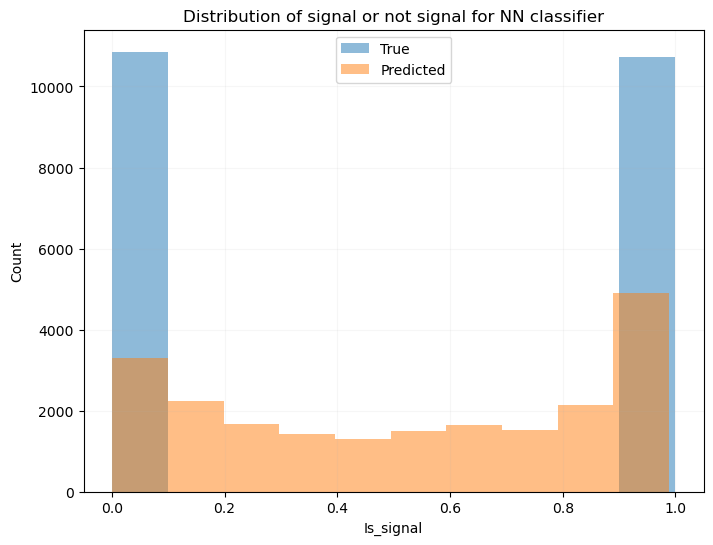

In [136]:
fig,ax = plt.subplots(figsize=(8, 6))

plt.hist(test_target_cut.values, alpha=0.5, label='True')
plt.hist(predict_cut_1, alpha=0.5, label='Predicted')

plt.xlabel('Is_signal')
plt.ylabel('Count')
plt.title('Distribution of signal or not signal for NN classifier')

plt.legend()
plt.grid(alpha=0.1)
plt.show()

Yup, using the cut data makes the NN predict less signal/not signals correctly

I think from here I'll revert back to the uncut data even though it also didn't perform well lol

In [138]:
# making a data frame with our predictions of a signal
mega_predict_df = pd.DataFrame(mega_input_data, columns = ['lep1_pt', 'lep2_pt', 'fatjet_pt', 'fatjet_eta', 'fatjet_D2', 'Zll_mass', 'Zll_pt', 'MET'])
mega_predict_df['signal_pred'] = mega_predict.flatten().tolist()
mega_predict_df["reco_zv_mass"] = mega_df["reco_zv_mass"].values.tolist()
mega_predict_df["FullEventWeight"] = mega_df["FullEventWeight"].values.tolist()
mega_predict_df["isSignal"] = mega_df["isSignal"].values.tolist()

mega_predict_df

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,signal_pred,reco_zv_mass,FullEventWeight,isSignal
0,1.083126,-1.030119,-0.041174,-0.000069,-0.141300,2.649218,0.801134,0.032589,0.710678,1014320.10,0.387345,0.0
1,-0.699421,-0.928481,-0.791630,-1.062728,-0.025641,-2.211578,-0.750343,1.258202,0.238735,240295.97,0.172328,0.0
2,-0.110158,-0.833040,-0.461349,0.704566,0.216104,-0.221695,-0.258498,0.035015,0.100997,471285.40,0.371392,0.0
3,-0.309555,-1.061220,0.539185,0.096823,-0.387491,-0.455217,-0.504411,0.038029,0.597161,495503.10,0.309902,0.0
4,-0.085727,-0.943981,-0.601698,-1.822267,0.278241,-0.176588,-0.315697,0.223106,0.082257,498823.40,0.202772,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6876967,0.610262,2.736318,0.779128,1.348380,-0.435264,-0.028409,1.225760,-0.078619,0.978984,1054015.90,0.080738,1.0
6876968,0.671958,0.375078,0.527858,-1.499202,-0.241179,-0.380291,0.736893,-0.050055,0.988393,875460.00,0.076554,1.0
6876969,1.374536,3.024294,-0.738632,-0.372655,-0.399088,0.075271,1.990665,0.077378,0.994608,963595.50,0.076300,1.0
6876970,0.889261,0.549461,0.571745,-0.579459,-0.319188,-0.072120,1.006495,-0.167988,0.990904,978088.25,0.073220,1.0


In [139]:
# defining the rejection of events that have a predicted probability for the isSignal target feature less than 50%
cut = mega_predict_df[mega_predict_df.signal_pred >= 0.5]
cut

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,signal_pred,reco_zv_mass,FullEventWeight,isSignal
0,1.083126,-1.030119,-0.041174,-0.000069,-0.141300,2.649218,0.801134,0.032589,0.710678,1014320.10,0.387345,0.0
3,-0.309555,-1.061220,0.539185,0.096823,-0.387491,-0.455217,-0.504411,0.038029,0.597161,495503.10,0.309902,0.0
5,0.958931,1.758317,-0.014071,-1.183404,-0.226322,6.456606,0.956082,0.086895,0.941111,921642.75,0.166699,0.0
7,0.058806,-0.615680,1.167609,0.129756,-0.283208,-0.490180,-0.002913,0.433022,0.925995,666803.80,0.177015,0.0
9,-0.280035,-0.695093,0.304411,1.017574,-0.329118,-1.616238,-0.320687,0.363396,0.934997,563217.30,0.176145,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6876967,0.610262,2.736318,0.779128,1.348380,-0.435264,-0.028409,1.225760,-0.078619,0.978984,1054015.90,0.080738,1.0
6876968,0.671958,0.375078,0.527858,-1.499202,-0.241179,-0.380291,0.736893,-0.050055,0.988393,875460.00,0.076554,1.0
6876969,1.374536,3.024294,-0.738632,-0.372655,-0.399088,0.075271,1.990665,0.077378,0.994608,963595.50,0.076300,1.0
6876970,0.889261,0.549461,0.571745,-0.579459,-0.319188,-0.072120,1.006495,-0.167988,0.990904,978088.25,0.073220,1.0


### Plotting the “cleaned” reco zv mass mass spectrum:

In [140]:
predicted_range = cut[(cut["reco_zv_mass"] < 1.4e6) & (cut["reco_zv_mass"] > 0.8e6)]

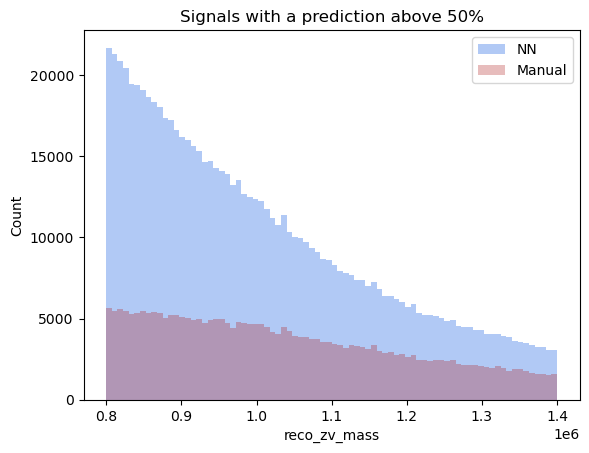

In [143]:
plt.hist(predicted_range["reco_zv_mass"] , bins = 80, label = 'NN', weights = predicted_range["FullEventWeight"], color = "cornflowerblue", alpha=0.5)
plt.hist(combined["reco_zv_mass"], bins = 80, label = 'Manual', weights = combined["FullEventWeight"], color = "firebrick", alpha=0.3)       
plt.legend()
plt.title("Signals with a prediction above 50%")
plt.xlabel("reco_zv_mass")
plt.ylabel("Count")
plt.show()

there is a tiny wee bump I swear

not sure whether the manual cuts or the NN makes it more visible though

Next I will repeat the two-fit procedure, assuming H1 and H0 hypotheses, and calculate the statistical significance of the signal-like deviation:

In [144]:
signal_predict = predicted_range[(predicted_range.isSignal==1)]
signal_predict

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,signal_pred,reco_zv_mass,FullEventWeight,isSignal
6826959,0.818358,5.344189,0.749296,-0.847721,-0.345134,-0.139318,2.020041,0.049771,0.951832,1063465.80,0.013603,1.0
6826960,0.649417,1.490984,0.131428,1.040204,-0.209705,-0.054839,0.971540,-0.017313,0.990297,974210.75,0.242178,1.0
6826961,0.327967,1.260361,1.190811,0.418322,-0.270190,-0.075499,0.658673,-0.102818,0.992703,996837.40,0.096412,1.0
6826962,0.724001,3.677421,0.455907,0.439002,-0.412502,-0.004506,1.576242,-0.101280,0.974047,989655.56,0.096373,1.0
6826963,0.307380,0.368365,-0.637344,1.212174,-0.382479,-0.084247,0.426059,-0.022409,0.970430,993398.30,0.073052,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6876967,0.610262,2.736318,0.779128,1.348380,-0.435264,-0.028409,1.225760,-0.078619,0.978984,1054015.90,0.080738,1.0
6876968,0.671958,0.375078,0.527858,-1.499202,-0.241179,-0.380291,0.736893,-0.050055,0.988393,875460.00,0.076554,1.0
6876969,1.374536,3.024294,-0.738632,-0.372655,-0.399088,0.075271,1.990665,0.077378,0.994608,963595.50,0.076300,1.0
6876970,0.889261,0.549461,0.571745,-0.579459,-0.319188,-0.072120,1.006495,-0.167988,0.990904,978088.25,0.073220,1.0


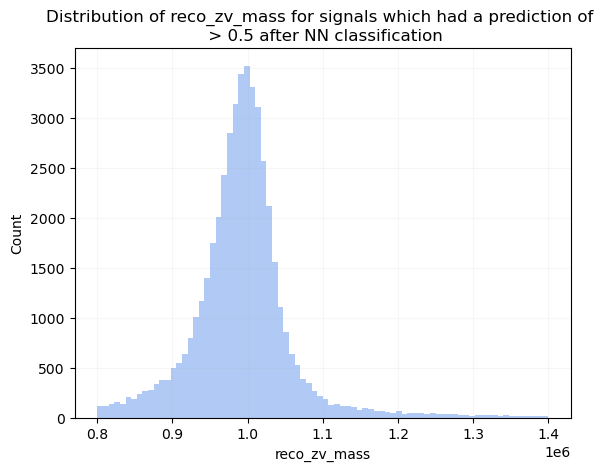

In [145]:
sighist, sighist_bins, sighist_patches = plt.hist(signal_predict['reco_zv_mass'], bins=80, color='cornflowerblue', alpha=0.5)

plt.xlabel("reco_zv_mass")
plt.ylabel("Count")
plt.title('Distribution of reco_zv_mass for signals which had a prediction of \n > 0.5 after NN classification')

plt.grid(alpha=0.1)
plt.show()

In [146]:
sig_cent = (sighist_bins[:-1] + sighist_bins[1:]) / 2

In [147]:
# function to fit a gaussian

def gaus(a, mu, sigma):
    
    x = sig_cent
    y = a * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    
    return y

In [148]:
# function which calculates a gaussian + lorentzian

def gaussian_lorentzian(a, b, mu_gaussian, sigma_gaussian, x0_lorentzian, gamma_lorentzian, weight_gaussian):
    
    x = sig_cent
    
    gaussian = a * np.exp(-0.5 * ((x - mu_gaussian) / sigma_gaussian) ** 2)
    lorentzian = b * (gamma_lorentzian / ((x - x0_lorentzian) ** 2 + gamma_lorentzian ** 2))
    combined = weight_gaussian * gaussian + (1 - weight_gaussian) * lorentzian
    
    return combined

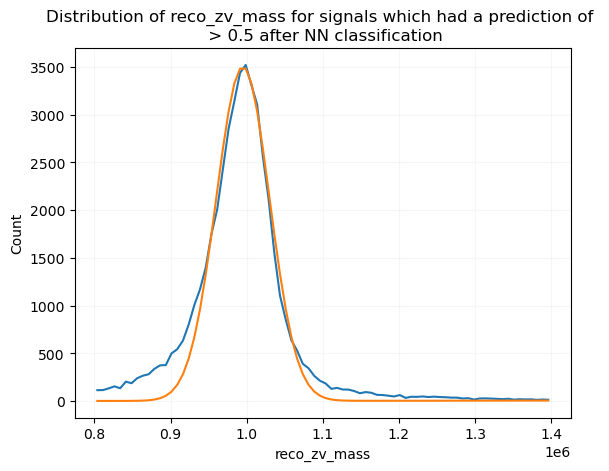

In [149]:
# plot the gaussian with the signal to try and find the right starting parameters

plt.plot(sig_cent, sighist)

plt.xlabel("reco_zv_mass")
plt.ylabel("Count")
plt.title('Distribution of reco_zv_mass for signals which had a prediction of \n > 0.5 after NN classification')

plt.plot(sig_cent, gaussian_lorentzian(a=35000, b=2.2e7, mu_gaussian=0.995e6, sigma_gaussian=35000, x0_lorentzian=2e6, gamma_lorentzian=100000, weight_gaussian=0.1))
plt.grid(alpha=0.1)
plt.show()

In [150]:
# function to calculate the chisquared for a gaussian + lorentzian fit

def chi_gaussian_lorentz(a, b, mu_gaussian, sigma_gaussian, x0_lorentzian, gamma_lorentzian, weight_gaussian=0.5):
    
    z = np.sum((signal_predict["FullEventWeight"].values)**2)
    x = sig_cent
    y = sighist
    
    
    return np.sum((y - gaussian_lorentzian(a, b, mu_gaussian, sigma_gaussian, x0_lorentzian, gamma_lorentzian, weight_gaussian))**2 / z )

In [151]:
new_m_sig = im(chi_gaussian_lorentz, a=35000, b=2.2e7, mu_gaussian=0.995e6, sigma_gaussian=35000, x0_lorentzian=2e6, gamma_lorentzian=100000, weight_gaussian=0.1)
new_m_sig.migrad()  # run optimiser
new_m_sig.hesse() 

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 124.9                      │             Nfcn = 1163              │
│ EDM = 1.3e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name             │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a                │  29.0e3   │   1.5e3   │            │            │         │         │       │
│ 1 │ b                │  89.1e6   │   2.3e6   │            │            │         │         │       │
│ 2 │ mu_gaussian      │ 1.0056e6  │ 0.0007e6  │            │            │         │         │       │
│ 3 │ sigma_gaussian   │  24.0e3   │   0.5e3   │            │            │         │         │       │
│ 4 │ x0_lorentzian    │  975.5e3  │   1.0e3   │            │            │         │         │       │
│ 5 │ gamma_lorentzian │  44.8e3   │   1.2e3   │            │            │         │         │       │
│ 6 │ weight_gaussian  │   0.073   │   0.004   │            │            │         │         │       │
└───┴──────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                  │                a                b      mu_gaussian   sigma_gaussian    x0_lorentzian gamma_lorentzian  weight_gaussian │
├──────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                a │         2.27e+06        -1.3842e9           -0.2e6           0.17e6           -0.4e6            0.4e6        -4.725874 │
│                b │        -1.3842e9         5.24e+12         1.2864e9       -1.00767e9         2.0617e9        -2.0724e9   -1.708974990e3 │
│      mu_gaussian │           -0.2e6         1.2864e9         4.46e+05          -0.30e6            0.5e6           -0.8e6      -795.401e-3 │
│   sigma_gaussian │           0.17e6       -1.00767e9          -0.30e6         2.43e+05          -0.39e6           0.51e6       580.262e-3 │
│    x0_lorentzian │           -0.4e6         2.0617e9            0.5e6          -0.39e6         9.69e+05           -0.9e6        -1.290430 │
│ gamma_lorentzian │            0.4e6        -2.0724e9           -0.8e6           0.51e6           -0.9e6         1.39e+06         1.344611 │
│  weight_gaussian │        -4.725874   -1.708974990e3      -795.401e-3       580.262e-3        -1.290430         1.344611         1.51e-05 │
└──────────────────┴────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [152]:
new_m_sig.fval

124.88136499736152

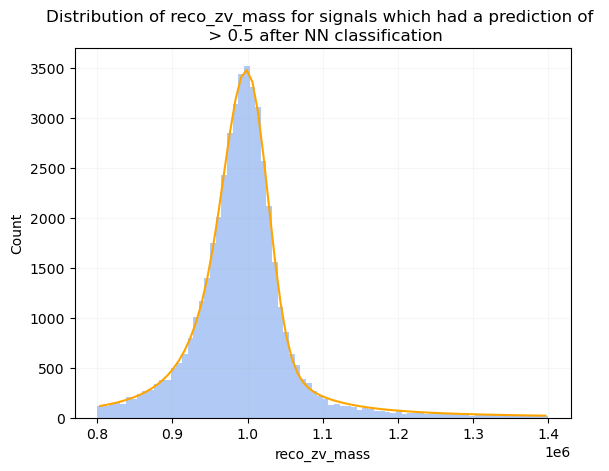

In [153]:
#plt.plot(sig_cent, sighist)

plt.hist(signal_predict['reco_zv_mass'], bins=80, color='cornflowerblue', alpha=0.5)

plt.plot(sig_cent, gaussian_lorentzian(a=new_m_sig.values[0], b=new_m_sig.values[1], mu_gaussian=new_m_sig.values[2], sigma_gaussian=new_m_sig.values[3], x0_lorentzian=new_m_sig.values[4], gamma_lorentzian=new_m_sig.values[5], weight_gaussian=new_m_sig.values[6]), color='orange')

plt.xlabel("reco_zv_mass")
plt.ylabel("Count")
plt.title('Distribution of reco_zv_mass for signals which had a prediction of \n > 0.5 after NN classification')

plt.grid(alpha=0.1)
plt.show()

So the $\chi ^2$ of 126 isn't amazing considering this looks like a fairly decent fit

Now modelling the background...

In [154]:
bg_predict = predicted_range[(predicted_range.isSignal==0)]
bg_predict

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,signal_pred,reco_zv_mass,FullEventWeight,isSignal
0,1.083126,-1.030119,-0.041174,-0.000069,-0.141300,2.649218,0.801134,0.032589,0.710678,1014320.10,0.387345,0.0
5,0.958931,1.758317,-0.014071,-1.183404,-0.226322,6.456606,0.956082,0.086895,0.941111,921642.75,0.166699,0.0
39,-0.271749,-0.742620,-0.071465,0.706079,-0.192720,-1.569232,-0.323988,0.302204,0.850679,841077.44,0.163275,0.0
40,2.165292,-0.184675,0.531110,1.089371,-0.130628,5.590255,1.731362,0.437380,0.744633,1133773.40,0.172671,0.0
64,1.550428,-1.066379,0.190370,0.230691,-0.216499,-1.505345,1.235270,0.696992,0.922345,977114.20,0.210835,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6826672,-0.061037,-0.986381,-0.729854,1.213887,-0.175549,-1.630548,-0.206777,0.368580,0.635191,855817.00,-2.083016,0.0
6826708,0.421069,-0.406965,-0.018400,1.081914,-0.030734,-1.206384,0.372966,0.046640,0.740710,1080134.80,0.879829,0.0
6826816,0.524856,-0.587884,0.452650,-0.595932,-0.136399,-1.534467,0.416426,1.154321,0.936103,1001791.75,0.743862,0.0
6826834,-0.574556,-0.529848,-0.776076,-1.978179,-0.147444,-1.146209,-0.616506,0.403683,0.602616,958904.44,-0.800503,0.0


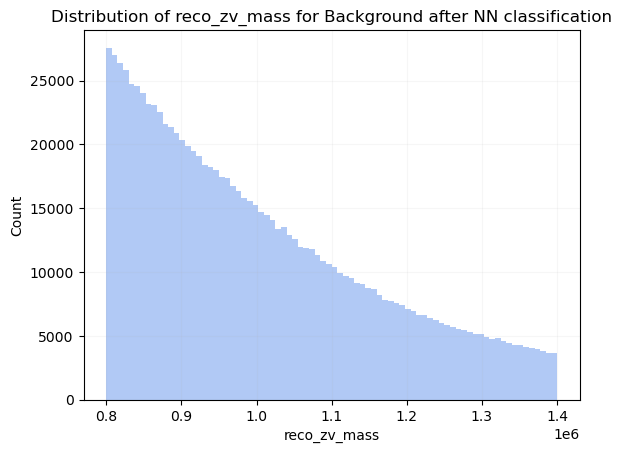

In [155]:
bghist, bghist_bins, bghist_patches = plt.hist(bg_predict['reco_zv_mass'], bins=80, color='cornflowerblue', alpha=0.5)

plt.xlabel("reco_zv_mass")
plt.ylabel("Count")
plt.title('Distribution of reco_zv_mass for Background after NN classification')

plt.grid(alpha=0.1)
plt.show()

In [156]:
bg_cent = (bghist_bins[:-1] + bghist_bins[1:]) / 2

In [157]:
def poly(a, b, c, x):

    y = (a*x**2) + (b*x) + c

    return y

In [158]:
def poly_chisquared(a, b, c):

    sigma = np.sum((bg_predict['FullEventWeight'].values)**2)

    x = bg_cent     # the x values at the centre of each bin (reco_zv_mass)
    y = bghist         # the y values for each bins (counts)

    chisq = np.sum(((y - poly(a, b, c, x))**2)/ sigma)

    return chisq

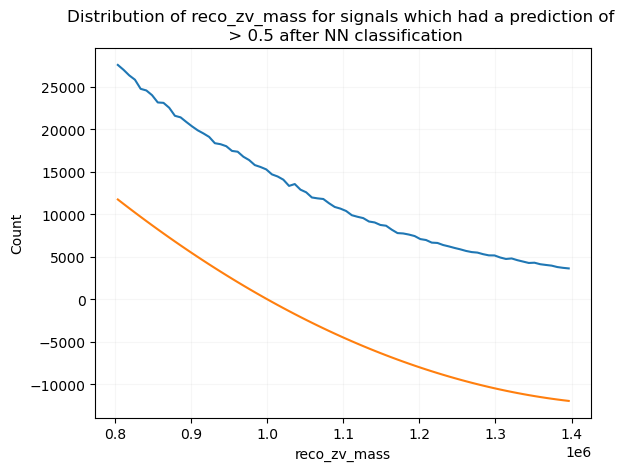

In [159]:
# plot the gaussian with the signal to try and find the right starting parameters

plt.plot(bg_cent, bghist)

plt.xlabel("reco_zv_mass")
plt.ylabel("Count")
plt.title('Distribution of reco_zv_mass for signals which had a prediction of \n > 0.5 after NN classification')

plt.plot(bg_cent, poly(a = 50e-9, b =-0.15, c = 100e3, x = bg_cent))
plt.grid(alpha=0.1)
plt.show()

In [160]:
new_m_bg = im(poly_chisquared,a = 50e-9, b =-0.15, c = 100e3)
new_m_bg.migrad()  # run optimiser
new_m_bg.hesse() 

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.212                      │              Nfcn = 91               │
│ EDM = 1.09e-17 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   57e-9   │   6e-9    │            │            │         │         │       │
│ 1 │ b    │  -0.165   │   0.012   │            │            │         │         │       │
│ 2 │ c    │   123e3   │    7e3    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────────────────────────────────────────────────────┐
│   │                  a                  b                  c │
├───┼──────────────────────────────────────────────────────────┤
│ a │            3.1e-17     -68.251999e-12 36.608115101074e-6 │
│ b │     -68.251999e-12           0.000151          -81.35599 │
│ c │ 36.608115101074e-6          -81.35599           4.41e+07 │
└───┴──────────────────────────────────────────────────────────┘

In [161]:
new_m_bg.fval

1.212378985472545

Pretty good $\chi ^2$

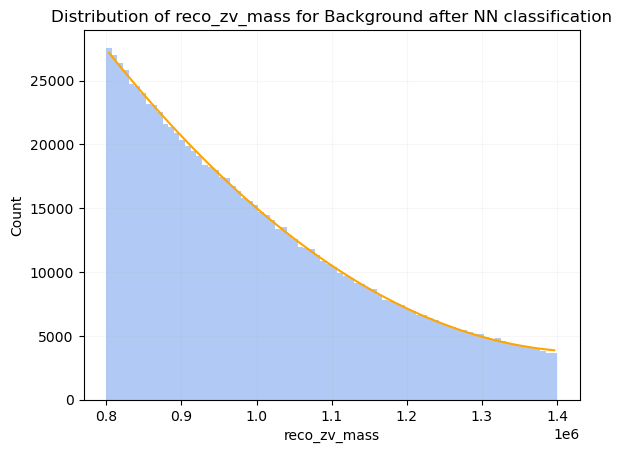

In [162]:
plt.hist(bg_predict['reco_zv_mass'], bins=80, color='cornflowerblue', alpha=0.5)

plt.plot(bg_cent, poly(a=new_m_bg.values[0], b=new_m_bg.values[1], c=new_m_bg.values[2], x=bg_cent), color='orange')

plt.xlabel("reco_zv_mass")
plt.ylabel("Count")
plt.title('Distribution of reco_zv_mass for Background after NN classification')

plt.grid(alpha=0.1)
plt.show()

Now modelling both the signal and background together:

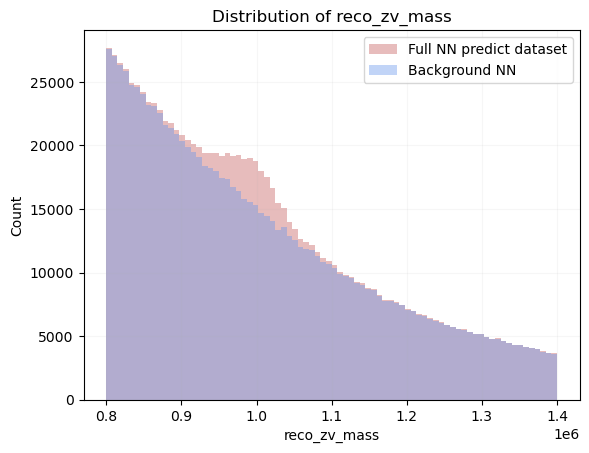

In [164]:

bothhist, bothhist_bins, bothhist_patches = plt.hist(predicted_range['reco_zv_mass'], bins=80, color='firebrick', alpha=0.3, label='Full NN predict dataset')
plt.hist(bg_predict['reco_zv_mass'], bins=80, color='cornflowerblue', alpha=0.4, label='Background NN')

plt.xlabel("reco_zv_mass")
plt.ylabel("Count")
plt.title('Distribution of reco_zv_mass')

plt.grid(alpha=0.1)
plt.legend()
plt.show()

In [165]:
both_cent = (bothhist_bins[:-1] + bothhist_bins[1:]) / 2

In [166]:
def combined_func(const1, const2, const3, const4):
    
    x = both_cent
    
    a = new_m_sig.values[0]
    b = new_m_sig.values[1]
    mu_gaussian = new_m_sig.values[2]
    sigma_gaussian = new_m_sig.values[3]
    x0_lorentzian = new_m_sig.values[4]
    gamma_lorentzian = new_m_sig.values[5]
    weight_gaussian = new_m_sig.values[6]
    
    gaussian = a * np.exp(-0.5 * ((x - mu_gaussian) / sigma_gaussian) ** 2)
    lorentzian = b * (gamma_lorentzian / ((x - x0_lorentzian) ** 2 + gamma_lorentzian ** 2))
    both = weight_gaussian * gaussian + (1 - weight_gaussian) * lorentzian
    
    poly = (const1*x**2) + (const2*x) + const3
    
    all = both + (const4 * poly)
    
    return all

In [167]:
def combined_chisq(const1, const2, const3, const4):
    
    z = np.sum((predicted_range["FullEventWeight"].values)**2)
    y = bothhist
    
    return np.sum((y - combined_func(const1, const2, const3, const4))**2 / z )

In [168]:
new_cmb_m = im(combined_chisq, const1 = 1e-10, const2 = -0.017, const3 = 26000, const4 = 0.99)
new_cmb_m.migrad()  # run optimiser
new_cmb_m.hesse() 

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.224                      │              Nfcn = 256              │
│ EDM = 1.02e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ const1 │ 13.69e-9  │  0.27e-9  │            │            │         │         │       │
│ 1 │ const2 │ -39.6e-3  │  0.4e-3   │            │            │         │         │       │
│ 2 │ const3 │  29.5e3   │   0.4e3   │            │            │         │         │       │
│ 3 │ const4 │   4.16    │   0.19    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────────────────────────────────┐
│        │             const1             const2             const3             const4 │
├────────┼─────────────────────────────────────────────────────────────────────────────┤
│ const1 │           7.51e-20      -81.30036e-15 -27.06463449591e-9    33.23725083e-12 │
│ const2 │      -81.30036e-15           1.84e-07      -102.92607e-3            1.85e-6 │
│ const3 │ -27.06463449591e-9      -102.92607e-3           1.96e+05             -69.24 │
│ const4 │    33.23725083e-12            1.85e-6             -69.24             0.0373 │
└────────┴─────────────────────────────────────────────────────────────────────────────┘

$\chi ^2$ of 0.9171 is pretty good!

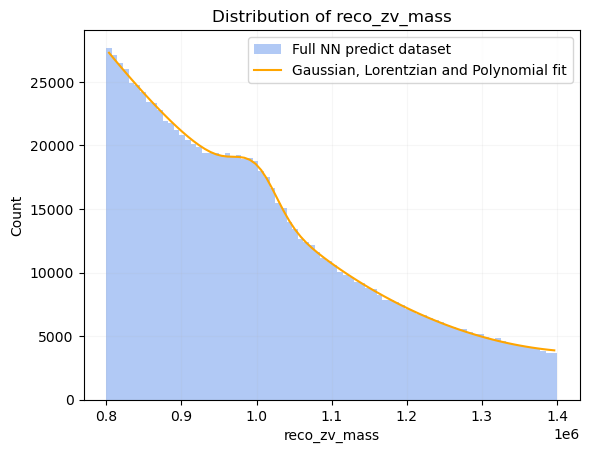

In [169]:
new_comb_y2 = combined_func(const1 = new_cmb_m.values[0], const2 = new_cmb_m.values[1], const3 = new_cmb_m.values[2], const4 = new_cmb_m.values[3])

plt.hist(predicted_range['reco_zv_mass'], bins=80, color='cornflowerblue', alpha=0.5, label='Full NN predict dataset')
plt.plot(both_cent, new_comb_y2, label='Gaussian, Lorentzian and Polynomial fit', color='orange')

plt.xlabel("reco_zv_mass")
plt.ylabel("Count")
plt.title('Distribution of reco_zv_mass')

plt.grid(alpha=0.1)
plt.legend()
plt.show()

Nice.

The $H_1$ hypothesis is the signal+background distribution, and the $H_0$ is the background only distribution

In [170]:
def poly_chisquared(a, b, c):

    sigma = np.sum((bg_predict['FullEventWeight'].values)**2)

    x = both_cent     # the x values at the centre of each bin (reco_zv_mass)
    y = bghist         # the y values for each bins (counts)

    chisq = np.sum(((y - poly(a, b, c, x))**2)/ sigma)

    return chisq

In [171]:
# running the minuit fitting a background only distribution

new_m_H0 = im(poly_chisquared, new_m_bg.values[0], new_m_bg.values[1], new_m_bg.values[2])

new_m_H0.migrad() 
new_m_H0.hesse() 

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.212                      │              Nfcn = 52               │
│ EDM = 1.09e-17 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   57e-9   │   6e-9    │            │            │         │         │       │
│ 1 │ b    │  -0.165   │   0.012   │            │            │         │         │       │
│ 2 │ c    │   123e3   │    7e3    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬──────────────────────────────────────────────────────────┐
│   │                  a                  b                  c │
├───┼──────────────────────────────────────────────────────────┤
│ a │            3.1e-17     -68.252072e-12 36.608155122448e-6 │
│ b │     -68.252072e-12           0.000151          -81.35608 │
│ c │ 36.608155122448e-6          -81.35608           4.41e+07 │
└───┴──────────────────────────────────────────────────────────┘

In [172]:
# running the minuit fitting a signal + background distribution

new_m_H1 = im(combined_chisq, const1 = new_cmb_m.values[0], const2 = new_cmb_m.values[1], const3 = new_cmb_m.values[2], const4 = new_cmb_m.values[3])

new_m_H1.migrad() 
new_m_H1.hesse() 

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.224                      │              Nfcn = 75               │
│ EDM = 3.02e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ const1 │ 13.69e-9  │  0.27e-9  │            │            │         │         │       │
│ 1 │ const2 │ -39.6e-3  │  0.4e-3   │            │            │         │         │       │
│ 2 │ const3 │  29.5e3   │   0.4e3   │            │            │         │         │       │
│ 3 │ const4 │   4.16    │   0.19    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────────────────────────────────┐
│        │             const1             const2             const3             const4 │
├────────┼─────────────────────────────────────────────────────────────────────────────┤
│ const1 │           7.52e-20      -81.29207e-15 -27.13293017174e-9    33.27199111e-12 │
│ const2 │      -81.29207e-15           1.84e-07      -102.91865e-3            1.85e-6 │
│ const3 │ -27.13293017174e-9      -102.91865e-3           1.96e+05             -69.32 │
│ const4 │    33.27199111e-12            1.85e-6             -69.32             0.0373 │
└────────┴─────────────────────────────────────────────────────────────────────────────┘

In [173]:
# taking the difference in chisq
new_delta_chisq = new_m_H1.fval - new_m_H0.fval
new_delta_chisq

0.011249094408405602

In [174]:
# 1 degree of freedom as only one parameter change between the two fits
dof = 1 

new_p_value_diff = 1-chi2.cdf(new_delta_chisq, dof) # calculate p-value using chi square cdf
new_n_sigmas_diff = erfinv(1-new_p_value_diff)*np.sqrt(2)
print("The P value = "+str(new_p_value_diff))
print("The Z value = " + str(new_n_sigmas_diff) + " sig")

The P value = 0.9155333605087523
The Z value = 0.10606174809235239 sig


Before using the NN and making kinematic cuts by eye, the p and z statistics were:

P value = 0.9682347737957101

Z value = 0.03982232973453958 sigmas

Although the # of sigmas for both is very far off of the 5 $\sigma$ needed to claim a signal from the background, using the NN increased $\sigma$ by almost an order of magnitude, so it definitely helped.

# Part 6: Impact of training sample on classifier

Next we want to re-incorporate reco zv mass, to see if it makes the signal more visible using the NN

In [175]:
# columns that we want i.e. now including reco_zv_mass 
reco_x = merged3[['lep1_pt', 'lep2_pt', 'fatjet_pt', 'fatjet_eta', 'fatjet_D2', 'Zll_mass', 'Zll_pt', 'MET', 'reco_zv_mass']]   
reco_y = merged3[['isSignal']] # this is our target

In [176]:
sc = preprocessing.StandardScaler()
reco_input_data = sc.fit_transform(reco_x)
# set random seed
Answertoallquestions= 42
# train - test split of dataset
reco_train_data , reco_test_data , reco_train_target , reco_test_target = model_selection.train_test_split(reco_input_data, reco_y, test_size =0.3 , random_state = Answertoallquestions)
print( reco_train_data.shape, reco_train_target.shape, reco_test_data.shape, reco_test_target.shape)

(70018, 9) (70018, 1) (30008, 9) (30008, 1)


In [177]:
batchSize=500
N_epochs=100

# building the second model with 8 inputs, 50 nodes and 5 layers
model_reco = my_model(9,50,5)

callbacks_ = [EarlyStopping(verbose = True , patience =10 , monitor = 'val_accuracy'), ModelCheckpoint('model.h5', monitor = 'val_accuracy', save_best_only = True , mode = 'max')]
reco_history = model_reco.fit(reco_train_data, reco_train_target, batch_size = batchSize, epochs = N_epochs, verbose = 1 , validation_data =( reco_test_data, reco_test_target), callbacks=callbacks_)

Epoch 1/100
141/141 [==============================] - 1s 4ms/step - loss: 0.3173 - accuracy: 0.8893 - val_loss: 0.1894 - val_accuracy: 0.9332
Epoch 2/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1882 - accuracy: 0.9338 - val_loss: 0.1824 - val_accuracy: 0.9356
Epoch 3/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1773 - accuracy: 0.9373 - val_loss: 0.1691 - val_accuracy: 0.9390
Epoch 4/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1738 - accuracy: 0.9379 - val_loss: 0.1695 - val_accuracy: 0.9388
Epoch 5/100
141/141 [==============================] - 1s 4ms/step - loss: 0.1703 - accuracy: 0.9388 - val_loss: 0.1643 - val_accuracy: 0.9403
Epoch 6/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1678 - accuracy: 0.9404 - val_loss: 0.1654 - val_accuracy: 0.9406
Epoch 7/100
141/141 [==============================] - 0s 3ms/step - loss: 0.1668 - accuracy: 0.9405 - val_loss: 0.1652 - val_accuracy: 0.9400

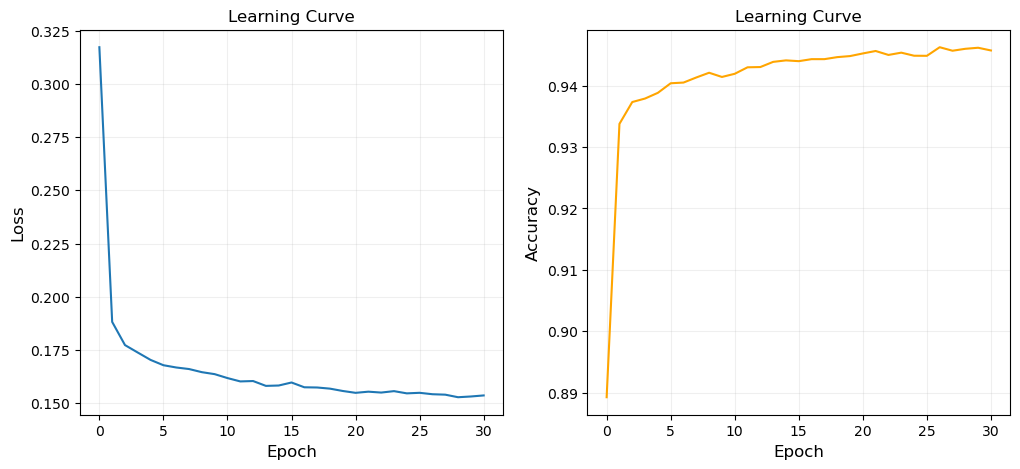

In [178]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].plot(reco_history.history['loss'])
axs[0].set_title('Learning Curve')
axs[0].set_xlabel('Epoch', fontsize=12)
axs[0].set_ylabel('Loss', fontsize=12)
axs[0].grid(alpha=0.2)


axs[1].plot(reco_history.history['accuracy'], color='orange')
axs[1].set_title('Learning Curve')
axs[1].set_xlabel('Epoch', fontsize=12)
axs[1].set_ylabel('Accuracy', fontsize=12)
axs[1].grid(alpha=0.2)

plt.show()

Yay this looks better than the training we did without reco_zv_mass!
We get a higher accuracy and lower loss :))

In [179]:
mega_df

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,isSignal,FullEventWeight
0,369495.34,9755.2705,345940.12,-0.001591,1.786927,187549.810,374316.600,41920.540,1014320.10,0.0,0.387345
1,36972.74,14584.7360,218057.10,-1.066937,2.296220,13106.807,51429.535,225618.530,240295.97,0.0,0.172328
2,146895.95,19119.7030,274339.25,0.704825,3.360730,84519.230,153790.270,42284.125,471285.40,0.0,0.371392
3,109699.72,8277.4480,444837.44,0.095546,0.702838,76138.640,102611.836,42735.938,495503.10,0.0,0.309902
4,151453.40,13848.2230,250422.77,-1.828396,3.634348,86138.000,141886.280,70475.780,498823.40,0.0,0.202772
...,...,...,...,...,...,...,...,...,...,...,...
6876967,281285.56,188722.1900,485725.50,1.350267,0.492475,91455.810,462688.160,25252.414,1054015.90,1.0,0.080738
6876968,292794.56,76524.9300,442907.28,-1.504514,1.347116,78827.555,360947.120,29533.623,875460.00,1.0,0.076554
6876969,423855.97,202405.7500,227088.28,-0.375119,0.651775,95176.640,621877.060,48633.637,963595.50,1.0,0.076300
6876970,333331.06,84810.9500,450385.88,-0.582446,1.003607,89887.110,417055.560,11857.587,978088.25,1.0,0.073220


In [180]:
# columns that we want i.e. ignoring reco_zv_mass and FullEventWeight
new_mega_x = mega_df[['lep1_pt', 'lep2_pt', 'fatjet_pt', 'fatjet_eta', 'fatjet_D2', 'Zll_mass', 'Zll_pt', 'MET', 'reco_zv_mass']]   
new_mega_y = mega_df[['isSignal']] # this is our target

In [181]:
sc = preprocessing.StandardScaler()
new_mega_input_data = sc.fit_transform(new_mega_x)
new_mega_predict = model_reco.predict(new_mega_input_data)

214906/214906 [==============================] - 89s 415us/step


In [182]:
# making a data frame with our predictions of a signal
new_mega_predict_df = pd.DataFrame(new_mega_input_data, columns = ['lep1_pt', 'lep2_pt', 'fatjet_pt', 'fatjet_eta', 'fatjet_D2', 'Zll_mass', 'Zll_pt', 'MET', 'reco_zv_mass'])
new_mega_predict_df['signal_pred'] = new_mega_predict.flatten().tolist()
new_mega_predict_df["reco_zv_mass"] = mega_df["reco_zv_mass"].values.tolist()
new_mega_predict_df["FullEventWeight"] = mega_df["FullEventWeight"].values.tolist()
new_mega_predict_df["isSignal"] = mega_df["isSignal"].values.tolist()

new_mega_predict_df

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,signal_pred,FullEventWeight,isSignal
0,1.083126,-1.030119,-0.041174,-0.000069,-0.141300,2.649218,0.801134,0.032589,1014320.10,0.743056,0.387345,0.0
1,-0.699421,-0.928481,-0.791630,-1.062728,-0.025641,-2.211578,-0.750343,1.258202,240295.97,0.080944,0.172328,0.0
2,-0.110158,-0.833040,-0.461349,0.704566,0.216104,-0.221695,-0.258498,0.035015,471285.40,0.021745,0.371392,0.0
3,-0.309555,-1.061220,0.539185,0.096823,-0.387491,-0.455217,-0.504411,0.038029,495503.10,0.019923,0.309902,0.0
4,-0.085727,-0.943981,-0.601698,-1.822267,0.278241,-0.176588,-0.315697,0.223106,498823.40,0.012550,0.202772,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6876967,0.610262,2.736318,0.779128,1.348380,-0.435264,-0.028409,1.225760,-0.078619,1054015.90,0.879323,0.080738,1.0
6876968,0.671958,0.375078,0.527858,-1.499202,-0.241179,-0.380291,0.736893,-0.050055,875460.00,0.994205,0.076554,1.0
6876969,1.374536,3.024294,-0.738632,-0.372655,-0.399088,0.075271,1.990665,0.077378,963595.50,0.993152,0.076300,1.0
6876970,0.889261,0.549461,0.571745,-0.579459,-0.319188,-0.072120,1.006495,-0.167988,978088.25,0.964655,0.073220,1.0


In [183]:
# defining the rejection of events that have a predicted probability for the isSignal target feature less than 50%
new_cut = new_mega_predict_df[new_mega_predict_df.signal_pred >= 0.5]
new_cut

,lep1_pt,lep2_pt,fatjet_pt,fatjet_eta,fatjet_D2,Zll_mass,Zll_pt,MET,reco_zv_mass,signal_pred,FullEventWeight,isSignal
0,1.083126,-1.030119,-0.041174,-0.000069,-0.141300,2.649218,0.801134,0.032589,1014320.10,0.743056,0.387345,0.0
5,0.958931,1.758317,-0.014071,-1.183404,-0.226322,6.456606,0.956082,0.086895,921642.75,0.979407,0.166699,0.0
7,0.058806,-0.615680,1.167609,0.129756,-0.283208,-0.490180,-0.002913,0.433022,666803.80,0.749828,0.177015,0.0
9,-0.280035,-0.695093,0.304411,1.017574,-0.329118,-1.616238,-0.320687,0.363396,563217.30,0.889267,0.176145,0.0
13,-0.183162,-1.033354,-0.634186,-1.833476,-0.316967,-0.809025,-0.310958,0.208639,581399.60,0.660463,0.192764,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6876967,0.610262,2.736318,0.779128,1.348380,-0.435264,-0.028409,1.225760,-0.078619,1054015.90,0.879323,0.080738,1.0
6876968,0.671958,0.375078,0.527858,-1.499202,-0.241179,-0.380291,0.736893,-0.050055,875460.00,0.994205,0.076554,1.0
6876969,1.374536,3.024294,-0.738632,-0.372655,-0.399088,0.075271,1.990665,0.077378,963595.50,0.993152,0.076300,1.0
6876970,0.889261,0.549461,0.571745,-0.579459,-0.319188,-0.072120,1.006495,-0.167988,978088.25,0.964655,0.073220,1.0


In [184]:
new_predicted_range = new_cut[(new_cut["reco_zv_mass"] < 1.4e6) & (new_cut["reco_zv_mass"] > 0.8e6)]

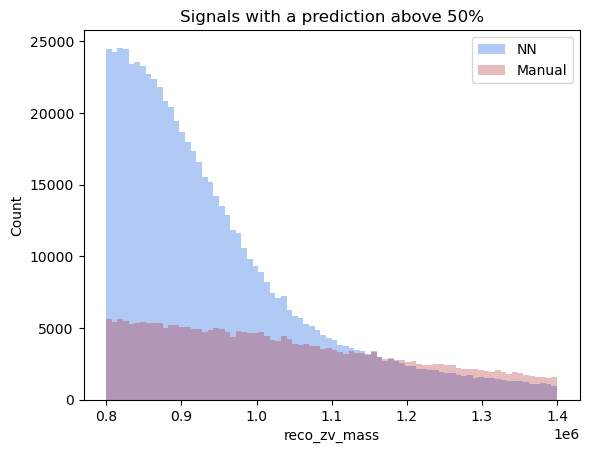

In [185]:
plt.hist(new_predicted_range["reco_zv_mass"] , bins = 80, label = 'NN', weights = new_predicted_range["FullEventWeight"], color = "cornflowerblue", alpha=0.5)
plt.hist(combined["reco_zv_mass"], bins = 80, label = 'Manual', weights = combined["FullEventWeight"], color = "firebrick", alpha=0.3)       
plt.legend()
plt.title("Signals with a prediction above 50%")
plt.xlabel("reco_zv_mass")
plt.ylabel("Count")
plt.show()

In [186]:
new_bg_predict = new_predicted_range[(new_predicted_range.isSignal==0)]
new_sig_predict = new_predicted_range[(new_predicted_range.isSignal==1)]

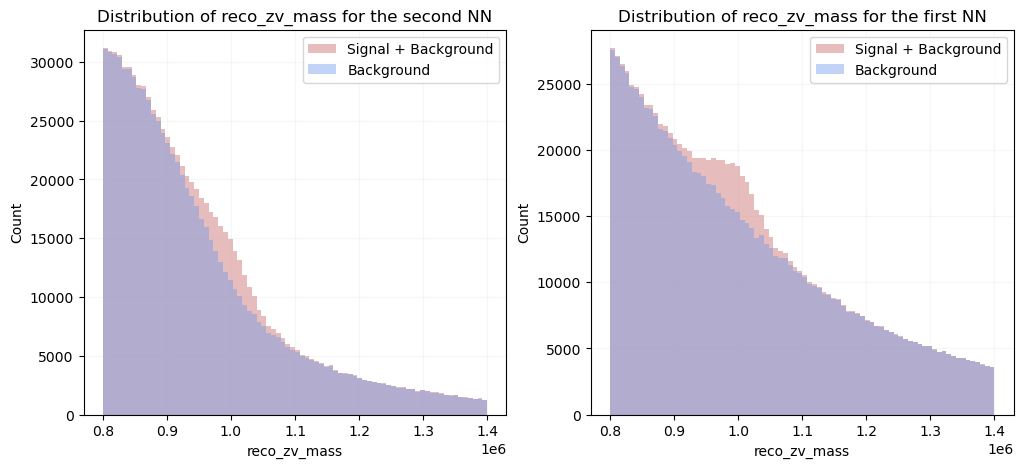

In [187]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].hist(new_predicted_range['reco_zv_mass'], bins=80, color='firebrick', alpha=0.3, label='Signal + Background')
axs[0].hist(new_bg_predict['reco_zv_mass'], bins=80, color='cornflowerblue', alpha=0.4, label='Background')
axs[0].grid(alpha=0.1)
axs[0].legend()
axs[0].set_title('Distribution of reco_zv_mass for the second NN')
axs[0].set_xlabel('reco_zv_mass')
axs[0].set_ylabel('Count')

axs[1].hist(predicted_range['reco_zv_mass'], bins=80, color='firebrick', alpha=0.3, label='Signal + Background')
axs[1].hist(bg_predict['reco_zv_mass'], bins=80, color='cornflowerblue', alpha=0.4, label='Background')
axs[1].grid(alpha=0.1)
axs[1].legend()
axs[1].set_title('Distribution of reco_zv_mass for the first NN')
axs[1].set_xlabel('reco_zv_mass')
axs[1].set_ylabel('Count')

plt.show()

The peak actually looks more visible when we trained the NN without reco_zv_mass. However I think this might be because it mis-classified a lot.
The signal peak still stands out after the second run of NN training though, which is a success.

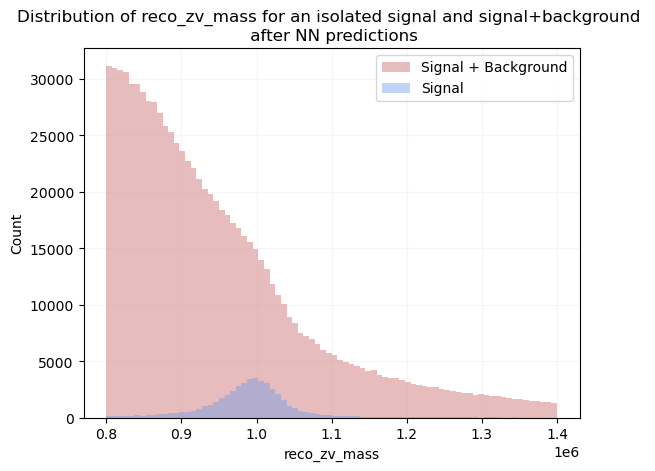

In [188]:
plt.hist(new_predicted_range['reco_zv_mass'], bins=80, color='firebrick', alpha=0.3, label='Signal + Background')
plt.hist(new_sig_predict['reco_zv_mass'], bins=80, color='cornflowerblue', alpha=0.4, label='Signal')

plt.xlabel("reco_zv_mass")
plt.ylabel("Count")
plt.title('Distribution of reco_zv_mass for an isolated signal and signal+background \n after NN predictions')

plt.grid(alpha=0.1)
plt.legend()
plt.show()

In this plot, it makes clear the impact that the signal has on the rest of the distribution.

Trying to quantify the search sensitivity now:

In conclusion, the behaviour of the ML classifier after incorporating variable reco zv mass in the NN training can be attributed to this property showing the largest difference between background and signal in the original kinematic histograms. Adding this into the training dataset will therefore make it easier for the model to determine whether an event is signal or backgound.